In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [2]:
import ee
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

import itertools
import sys
import re
import itertools
from io import StringIO
from tqdm.auto import tqdm
from pprint import pprint

import urllib.request
import requests

from dfply import *
import geopandas as gpd

from ast import literal_eval
from shapely.geometry import shape


# ! pip install geemap
# import geemap

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
from Modules.Modules import filter_exclude, get_img_df
from Modules.Parallize_df import parallelize_dataframe
from Modules.Global_Variables import proj_yr_selected

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# the NCP image mask
NCP_img_mask = ee.ImageCollection("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992").first().mask()
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

NCP_urban_maps = ee.Image("users/wangjinzhulala/China_built_up/06_temporal_corrected_classification/Mosaic_only_forward_China_huadong_sample_ensemble")
year_val_code = list(zip(range(1992,2020,3),range(10,0,-1)))

# import the 30m landcover of 2010
LUCC_NCP = {yr:ee.Image(f"users/wangjinzhulala/Paper_3/01_LUCC_1990_2019_china/CLCD_v01_{yr}").mask(NCP_img_mask) for yr in range(1990,2020)}
lucc_code = dict(zip([f"{i}" for i in range(1,10)],['Cropland','Forest','Shrub','Grassland','Water','Sonw','Barren','Impervious','Wetland']))

# get the pixel size for exporting img later
one_GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical")
GAEZ_pix_scale = one_GAEZ_img.projection().nominalScale().getInfo()

# the GAEZ_urban_encroach area
SSP_future_urban_map_stats_hist = pd.read_csv('./result_csv/SSP_future_urban_map_stats_hist.csv')

# read yearbook cropland area
yearbook_area = pd.read_csv('./result_csv/yearbook_area.csv')

# read the corrected GAEZ_2010_cropland
GAEZ_cropland_2010_corrected = pd.read_pickle('./result_csv/GAEZ_cropland_2010_corrected.pkl')

### 1) Explore the reclmation_area and cropland_increate_area

In [6]:
# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

In [7]:
# the reclamation data from Brett Nature paper
land_reclimate_invest = pd.read_csv('../Data/06_Yearbook/GDP_Population/land_reclimation_invest_ml_yuan.csv')
land_reclimate_invest = land_reclimate_invest.set_index('Province').stack().reset_index()
land_reclimate_invest.columns = ['Province','year','invest_1e6_CNY']
land_reclimate_invest['year'] = land_reclimate_invest['year'].astype(int)

land_reclimate_area = pd.read_csv('../Data/06_Yearbook/GDP_Population/land_reclimation_area_k_ha.csv')
land_reclimate_area = land_reclimate_area.set_index('Province').stack().reset_index()
land_reclimate_area.columns = ['Province','year','area_k_ha']
land_reclimate_area['year'] = land_reclimate_area['year'].astype(int)


# the cropland increase from yearbook
yearbook_reclamation = pd.read_csv('../Data/06_Yearbook/GDP_Population/yearbook_land_reclimation_total_area_ha.csv')
yearbook_reclamation = yearbook_reclamation.set_index('Province').stack().reset_index().replace(city_cn_en)
yearbook_reclamation.columns = ['Province','year','yearbook_reclamation_ha']
yearbook_reclamation['yearbook_reclamation_kha'] = yearbook_reclamation['yearbook_reclamation_ha'] / 1000
yearbook_reclamation['year'] = yearbook_reclamation['year'].astype(int)

yearbook_cropland_increase = pd.read_csv('../Data/06_Yearbook/GDP_Population/yearbook_land_reclimation_cropland_increase_ha.csv')
yearbook_cropland_increase = yearbook_cropland_increase.set_index('Province').stack().reset_index().replace(city_cn_en)
yearbook_cropland_increase.columns = ['Province','year','yearbook_cropland_increase_ha']
yearbook_cropland_increase['yearbook_cropland_increase_kha'] = yearbook_cropland_increase['yearbook_cropland_increase_ha'] / 1000
yearbook_cropland_increase['year'] = yearbook_cropland_increase['year'].astype(int)

# merge all land reclamation data
land_reclimation_record = land_reclimate_invest.merge(land_reclimate_area).merge(yearbook_reclamation)\
              .merge(yearbook_cropland_increase) >> mask(X.Province.isin(city_cn_en.values()))

#### 1-1) The reclimation data from Brett Nature paper is the same with the yearbook reclamation records
- there are some outliers, but overall, these two datasets are the same 

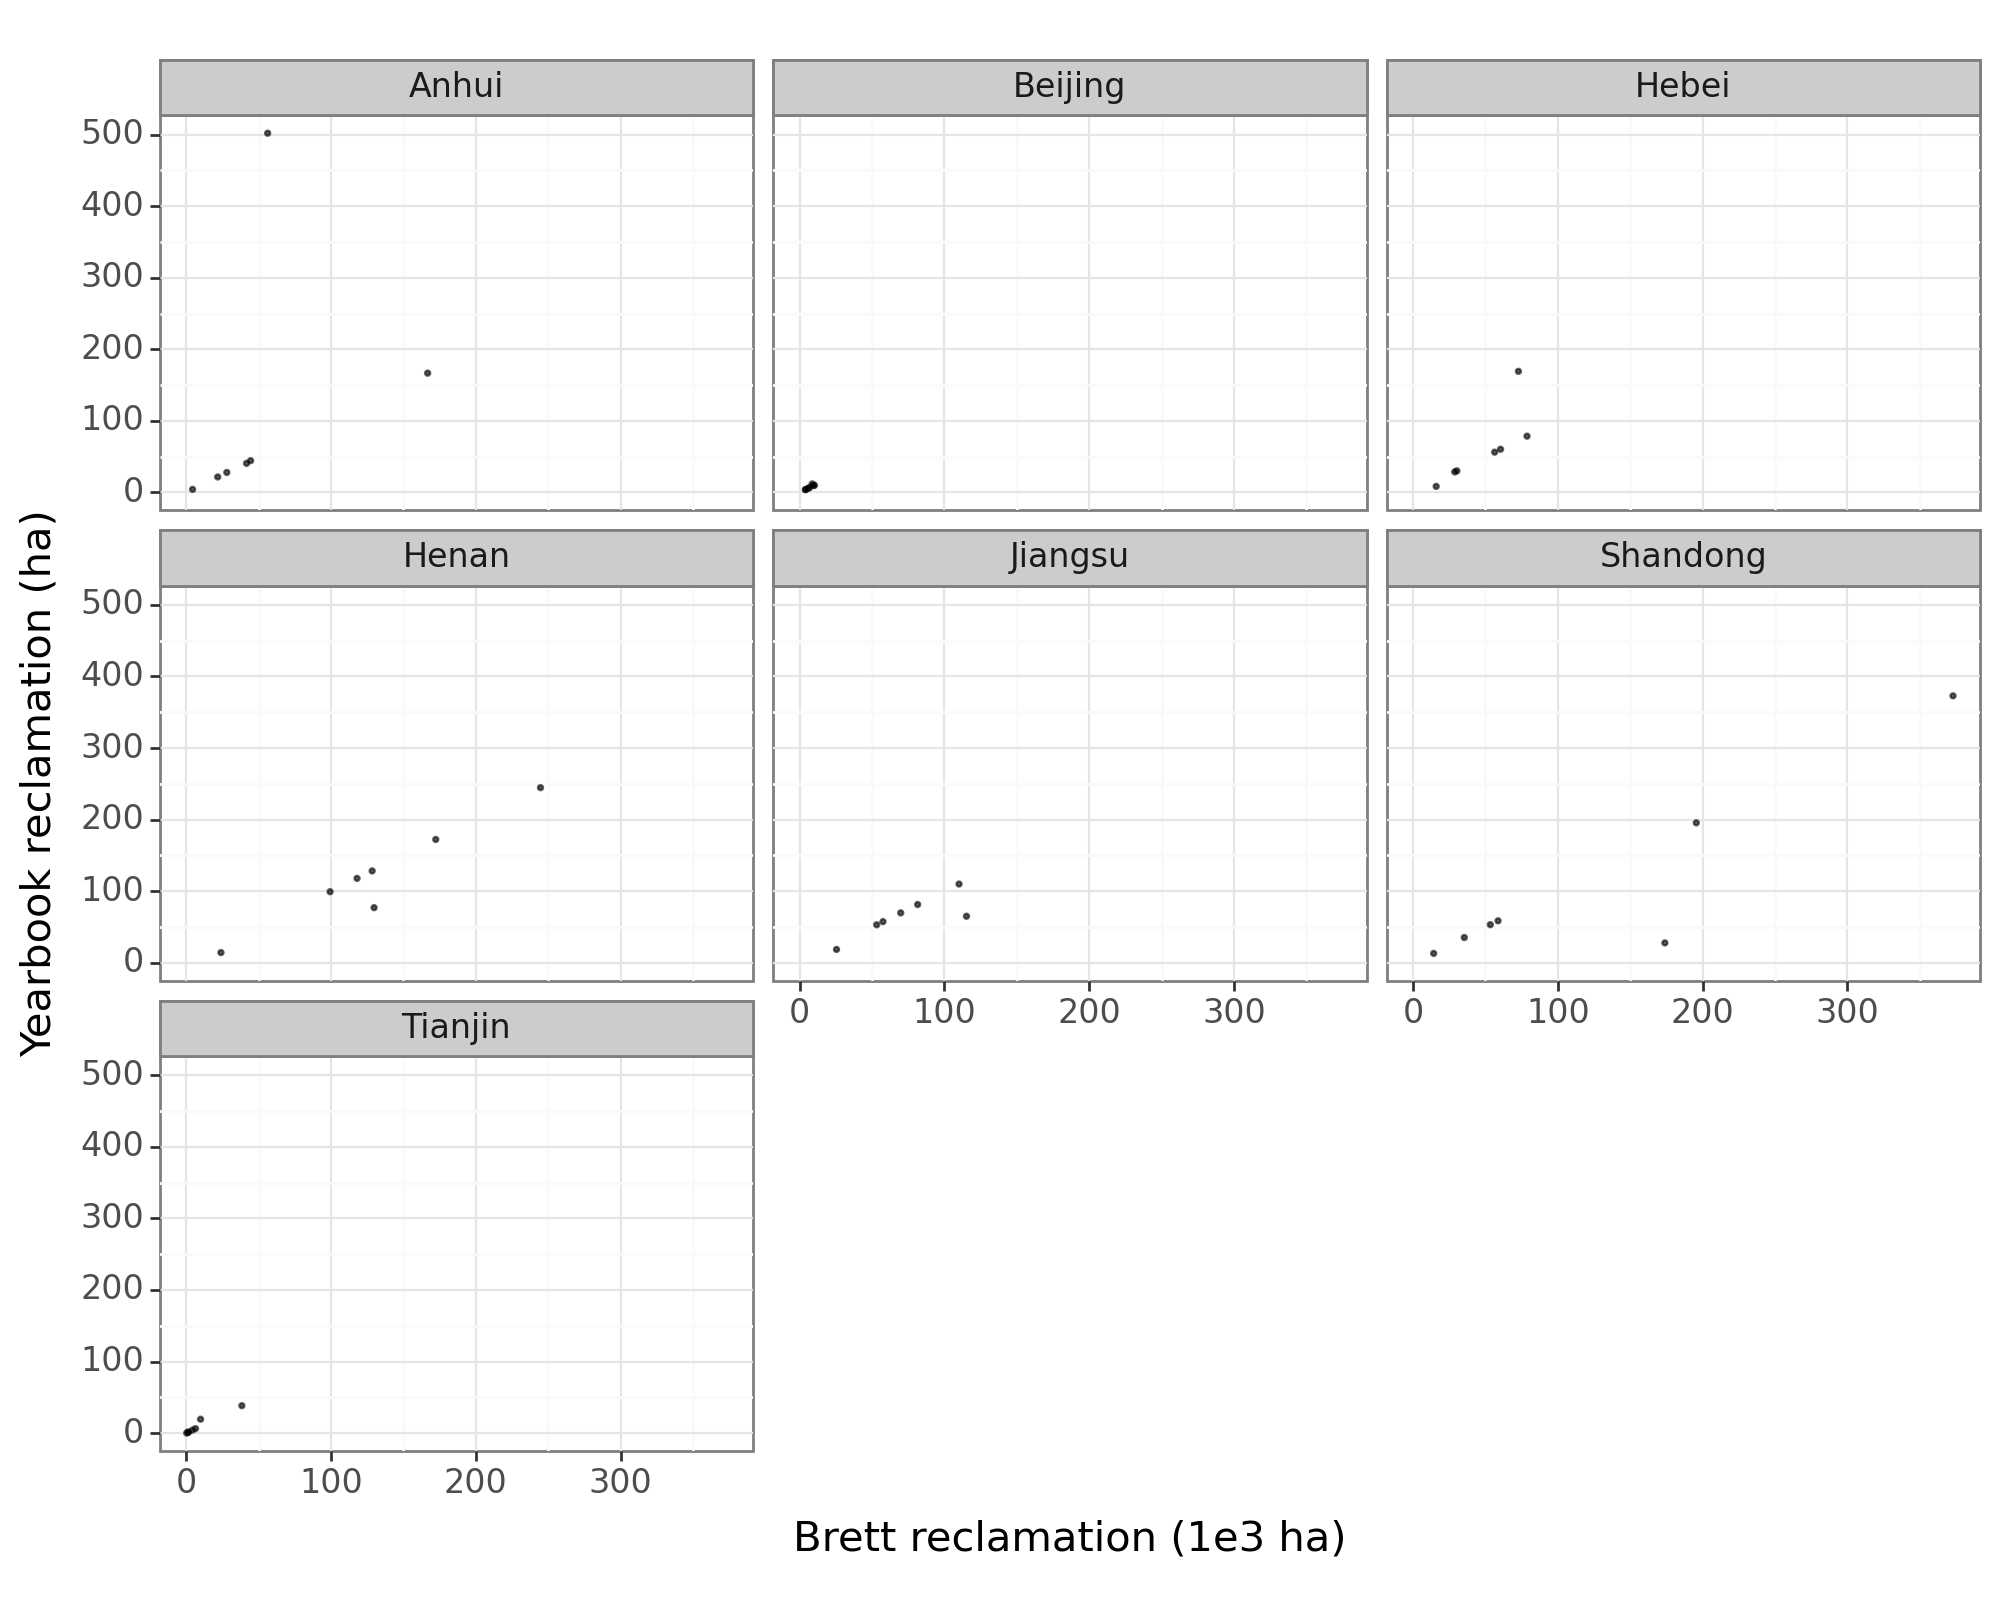

<Figure Size: (1000 x 800)>

In [8]:
# plot the area change
plotnine.options.figure_size = (10,8)
plotnine.options.dip = 100

(ggplot(land_reclimation_record)
+ geom_point(aes(x='area_k_ha',y='yearbook_reclamation_kha'),size=0.5,alpha=0.6)
+ facet_wrap('Province',ncol=3)
+ theme_bw(base_size=15)
+ xlab('Brett reclamation (1e3 ha)')
+ ylab('Yearbook reclamation (ha)')
 )

#### 2-2) Rclamation | Cropland_increase, which should be used as the cropland increament?
- We believe the urban_encroach_area should be mitigated by Rclamation_area or Cropland_increase
- GAEZ_2010_crop_area - urban_encroach + **?** = yearbook_record
- whichever data from Rclamation | Cropland_increase meet above equation, will be the cropland increament in this study

In [9]:
# get the sum of yearbook cropland area records
yearbook_area_sum = yearbook_area.groupby('year').sum().reset_index()
yearbook_area_sum.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\3327602713.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,year,area_yearbook_kha
0,2002,28149.15
1,2003,26923.11
2,2004,27523.82
3,2005,28873.97
4,2006,30566.23


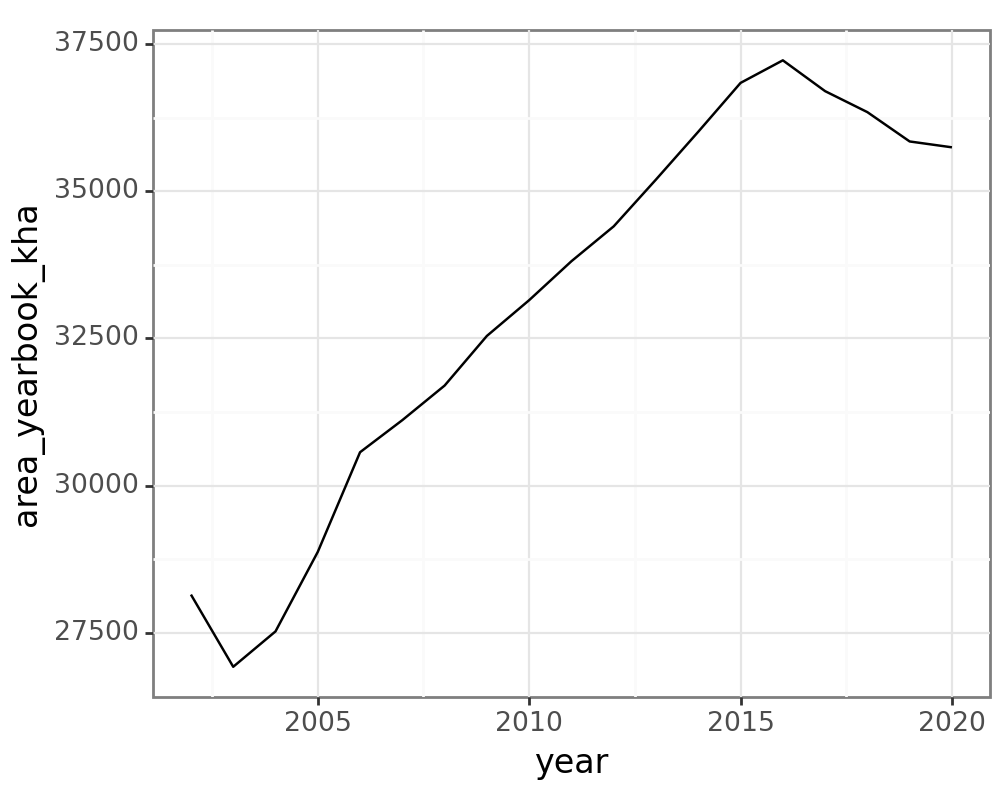

<Figure Size: (500 x 400)>

In [10]:
# plot the area change
plotnine.options.figure_size = (5,4)
plotnine.options.dip = 100

# plot the trend
(ggplot()
 + geom_line(yearbook_area_sum,aes(x='year',y='area_yearbook_kha'))
 + theme_bw(base_size=12)
)

In [11]:
# get the urban encroachment area
GAEZ_urban_encroach = SSP_future_urban_map_stats_hist >> select(['year','crop','water','GAEZ_actual_encroachment_kha'])
GAEZ_urban_encroach_sum = GAEZ_urban_encroach.groupby('year').sum().reset_index()
GAEZ_urban_encroach_sum

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\3110053154.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,year,GAEZ_actual_encroachment_kha
0,2012,1930.254830
1,2015,2433.908131
2,2018,3140.590916


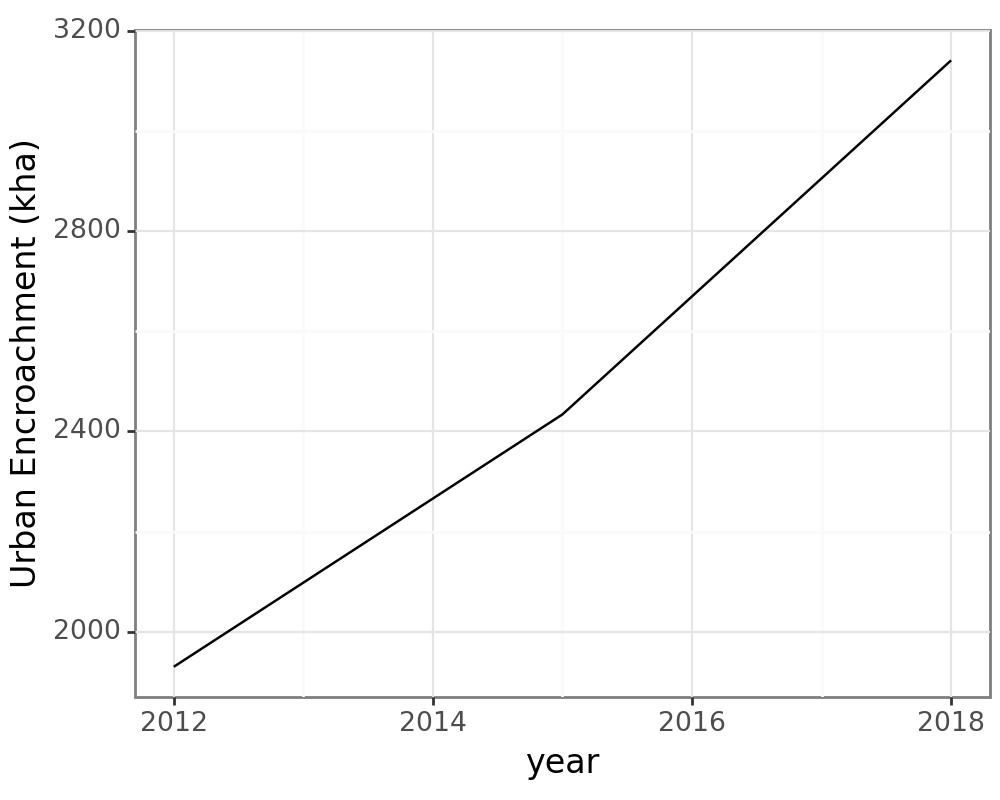

<Figure Size: (500 x 400)>

In [12]:
# plot the trend
(ggplot()
 + geom_line(GAEZ_urban_encroach_sum,aes(x='year',y='GAEZ_actual_encroachment_kha'))
 + theme_bw(base_size=12)
 + ylab('Urban Encroachment (kha)')
)

In [13]:
# get the reclamation/urban_increase area
increase_area = land_reclimation_record.copy()
increase_area = increase_area.sort_values(['Province','year']).reset_index(drop=True)
increase_area['cumsum_reclamation_kha'] = increase_area.groupby('Province').apply(lambda df:df.cumsum())['yearbook_reclamation_kha']
increase_area['cumsum_cropland_increase_kha'] = increase_area.groupby('Province').apply(lambda df:df.cumsum())['yearbook_cropland_increase_kha']
increase_area = increase_area >> select(['Province','year','cumsum_reclamation_kha','cumsum_cropland_increase_kha'])

increase_area_sum = increase_area.groupby(['year']).sum().reset_index()
increase_area_sum

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\91840602.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\91840602.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\9184

,year,cumsum_reclamation_kha,cumsum_cropland_increase_kha
0,2009,352.61702,109.58483
1,2010,848.47680,223.62019
2,2011,1179.41500,312.97182
3,2012,1879.93897,399.88984
4,2013,2452.80133,501.62037
5,2014,2558.56277,529.48771
6,2015,3431.15098,567.74757


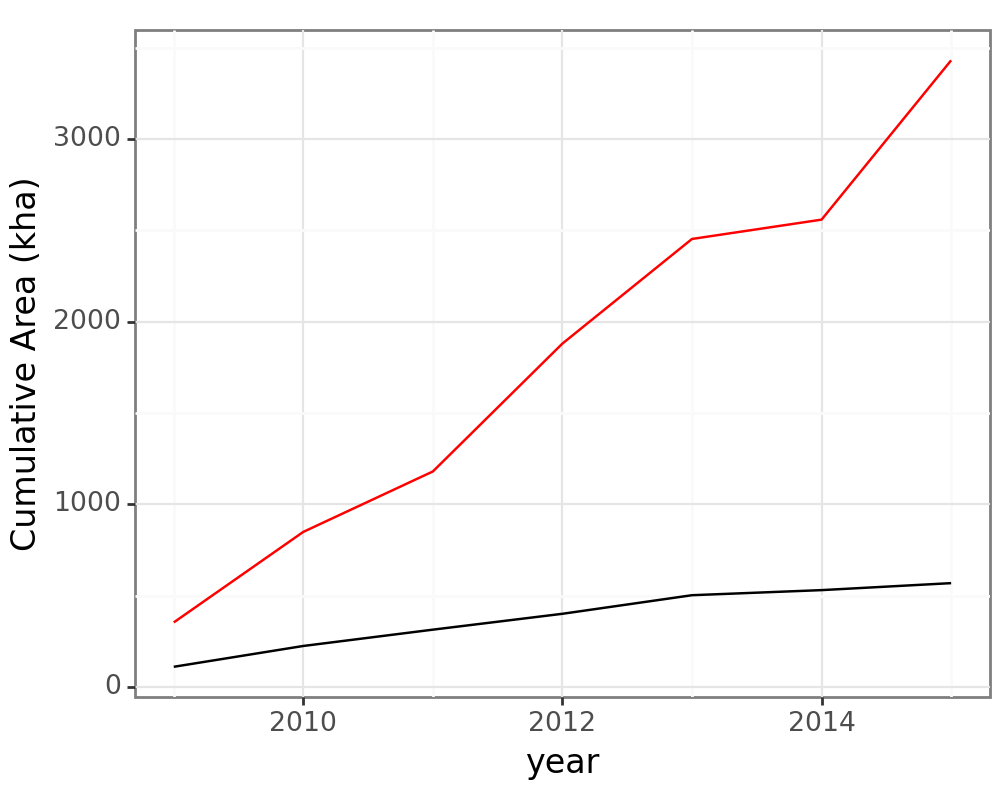

<Figure Size: (500 x 400)>

In [14]:
# plot the area change
plotnine.options.figure_size = (5,4)
plotnine.options.dip = 100

# plot the trend
(ggplot()
 + geom_line(increase_area_sum,aes(x='year',y='cumsum_reclamation_kha'),color='red')
 + geom_line(increase_area_sum,aes(x='year',y='cumsum_cropland_increase_kha'))
 + theme_bw(base_size=12)
 + ylab('Cumulative Area (kha)')
 + theme(legend_title=element_blank(),legend_position=(0.35,0.7),legend_background=element_blank())
)

#### 2-3) The cumsum_cropland_increase_kha should be used as the cropland increment.
- comparing the increase_area_sum with GAEZ_urban_encroach_sum
- we can see that the cumsum_cropland_increase_kha is much closer to GAEZ_actual_encroachment_kha
- so, cumsum_cropland_increase_kha will be used as the cropland increments

In [15]:
# compute the total croppand area
total_cropland_2010_img = ee.ImageCollection([ee.Image(path).unmask() 
                  for path in  GAEZ_cropland_2010_corrected['GAEZ_2010_cropland_corrcted']]).sum()
                  
total_cropland_2010_val = total_cropland_2010_img.reduceRegion(reducer='sum',geometry=NCP_shp.geometry(),scale=GAEZ_pix_scale)\
                          .getInfo()['b1']

In [16]:
# compute the cropland_area change under the reclamation/cropland_increase impacts

### IMPORTANT! Note we mutiplied the cropland_increase_area by 2,
### because its unit is (cropland_area) but the unit of the yearbook
### is (sowing_area). The (sowing_area = cropland_area * cropping_system).
### And the crops in the research area is harvested two times (wheat-maize).
df_cropland_area_change = GAEZ_urban_encroach_sum.merge(increase_area_sum)

df_cropland_area_change['final_increase_kha_raw'] = total_cropland_2010_val - df_cropland_area_change['GAEZ_actual_encroachment_kha'] \
                          + df_cropland_area_change['cumsum_cropland_increase_kha']

df_cropland_area_change['final_increase_kha_cropping_system'] = total_cropland_2010_val - df_cropland_area_change['GAEZ_actual_encroachment_kha'] \
                          + (df_cropland_area_change['cumsum_cropland_increase_kha'] * 2)

df_cropland_area_change['final_reclamation_kha'] = total_cropland_2010_val - df_cropland_area_change['GAEZ_actual_encroachment_kha'] \
                          + df_cropland_area_change['cumsum_reclamation_kha']

In [17]:
# append cropland_2010 to df_cropland_area_change
df_cropland_2010 = pd.DataFrame({ 'year':[2010],
                  'final_increase_kha_raw':[total_cropland_2010_val],
                  'final_increase_kha_cropping_system':[total_cropland_2010_val],
                  'final_reclamation_kha':[total_cropland_2010_val]})
df_cropland_area_change = pd.concat([df_cropland_2010,df_cropland_area_change])

In [18]:
df_cropland_area_change

,year,final_increase_kha_raw,final_increase_kha_cropping_system,final_reclamation_kha,GAEZ_actual_encroachment_kha,cumsum_reclamation_kha,cumsum_cropland_increase_kha
0,2010,33166.163817,33166.163817,33166.163817,NaN,NaN,NaN
0,2012,31635.798827,32035.688667,33115.847957,1930.254830,1879.93897,399.88984
1,2015,31300.003256,31867.750826,34163.406666,2433.908131,3431.15098,567.74757


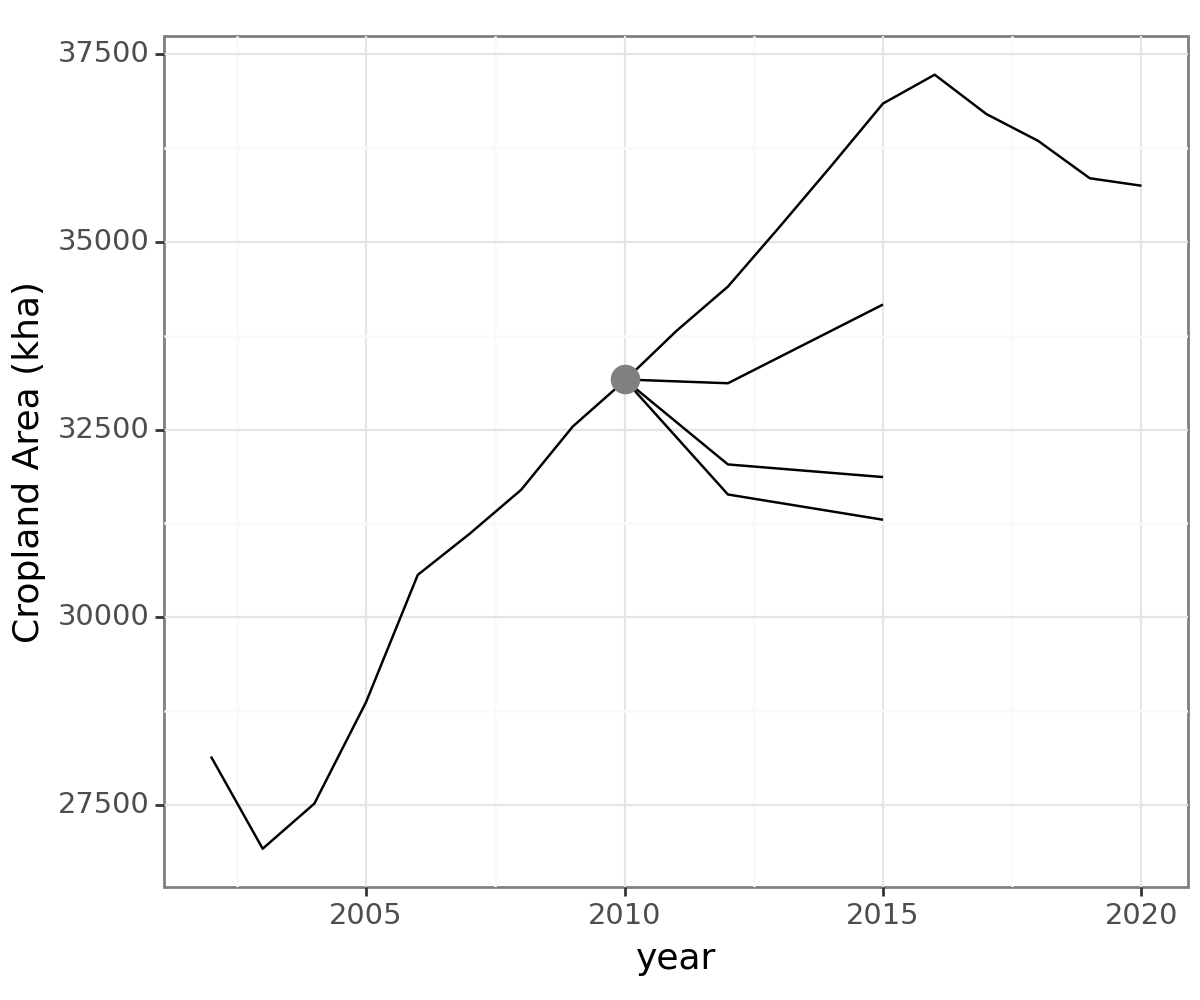

<Figure Size: (600 x 500)>

In [20]:
# plot the area change
plotnine.options.figure_size = (6,5)
plotnine.options.dip = 100

# plot the trend
(ggplot()
 # yearbook records
 + geom_line(yearbook_area_sum,aes(x='year',y='area_yearbook_kha'))
 # model cropland area without multiplying the cropping scale (2)
 + geom_line(df_cropland_area_change,aes(x='year',y='final_increase_kha_raw'))
 # model cropland area multiplying the cropping scale (2)
 + geom_line(df_cropland_area_change,aes(x='year',y='final_increase_kha_cropping_system',))
 # model cropland area with the cropland area increase from the total "Land Consolidation" project
 + geom_line(df_cropland_area_change,aes(x='year',y='final_reclamation_kha'))
 + geom_point(aes(x=2010,y=total_cropland_2010_val),size=5,color='grey')
 + theme_bw(base_size=13)
 + ylab('Cropland Area (kha)')
 + theme(legend_title=element_blank(),legend_position=(0.63,0.23),
         legend_background=element_blank(),legend_text=element_text(size=10),
         legend_key_size=13)
)

### 2) regression on the cropland_increase

#### 2-1) regression cropland_increase with GDP
- we can not see a good regression between GDP and cropland_increase

In [22]:
# read the GDP_China
china_GDP = pd.read_csv('../Data/06_Yearbook/GDP_Population/yearbook_GDP_China.csv').replace(city_cn_en) 
china_GDP = china_GDP.set_index('Province').stack().reset_index() >> mask(X.Province.isin(city_cn_en.values()))
china_GDP.columns = ['Province','year','GDP_1e8_yuan']
china_GDP['year'] = china_GDP['year'].astype(int)
china_GDP = china_GDP.sort_values(['Province','year']).reset_index(drop=True)

# get the cropland_increase each year
# remember to multiply the cropland_increase_area by 2
cropland_increase_delta = land_reclimation_record >> select(['Province','year','yearbook_cropland_increase_kha'])
cropland_increase_delta['yearbook_cropland_increase_kha'] = cropland_increase_delta['yearbook_cropland_increase_kha'] * 2
cropland_increase_delta = cropland_increase_delta.sort_values(['Province','year']).reset_index(drop=True)

# merge GDP with cropland_increase
crpland_increase_with_GDP = china_GDP.merge(cropland_increase_delta)
crpland_increase_with_GDP.head()

,Province,year,GDP_1e8_yuan,yearbook_cropland_increase_kha
0,Anhui,2009,10864.7,39.54442
1,Anhui,2010,13249.8,14.08586
2,Anhui,2011,16284.9,31.91798
3,Anhui,2012,18341.7,24.56592
4,Anhui,2013,20584.0,28.37012


C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


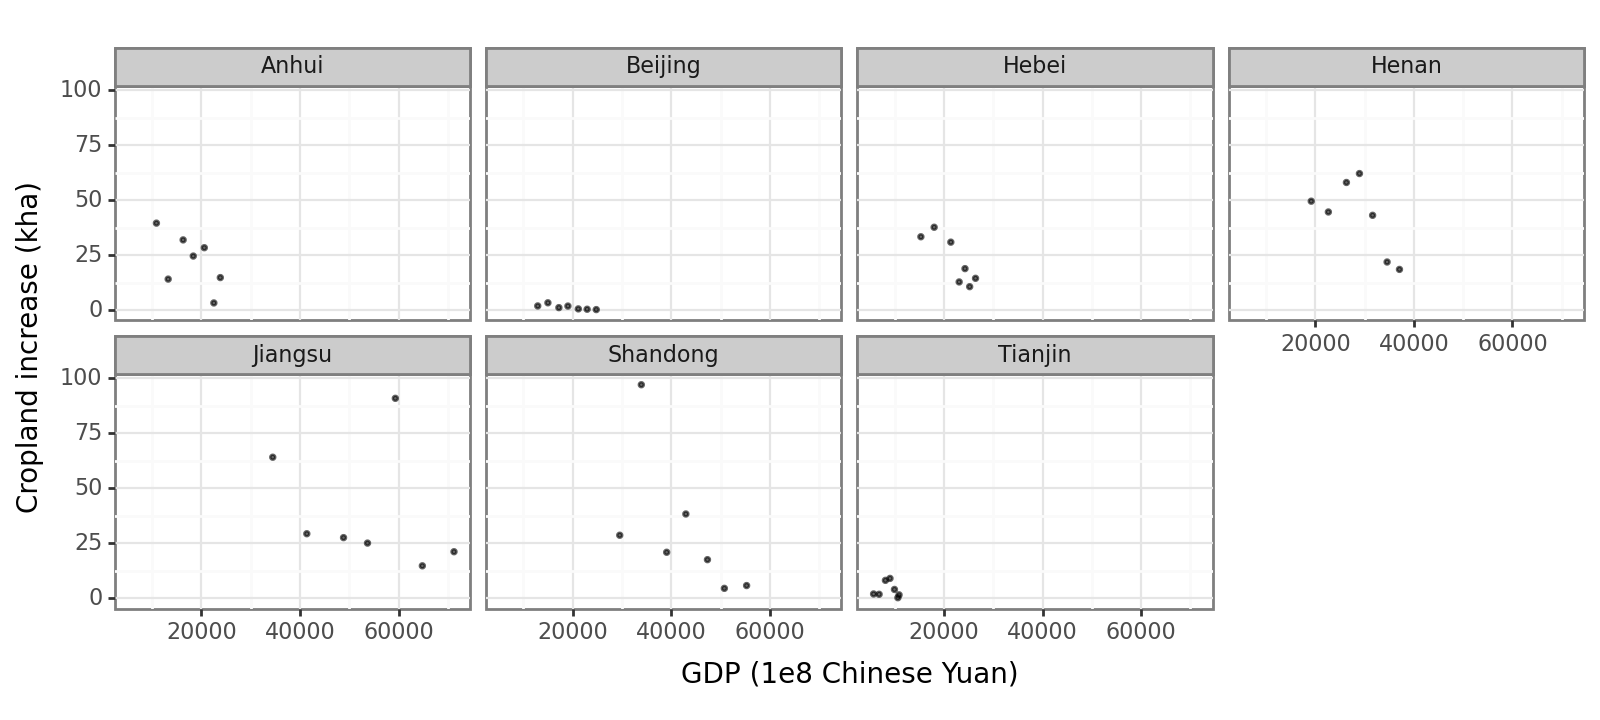

<Figure Size: (800 x 360)>

In [23]:
# plot the area change
plotnine.options.figure_size = (8,3.6)
plotnine.options.dip = 100

g = (ggplot()
+ geom_point(crpland_increase_with_GDP,aes(x='GDP_1e8_yuan',y='yearbook_cropland_increase_kha'),size=0.5,alpha=0.6)
+ xlab('GDP (1e8 Chinese Yuan)')
+ facet_wrap('Province',ncol=4)
+ theme_bw(base_size=10)
+ theme(subplots_adjust={'wspace': 0.15})
+ ylab('Cropland increase (kha)')
 )

g

In [24]:
g.save('../Figs/sup_8_1_GDP_fit_reclamation.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 3.6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_8_1_GDP_fit_reclamation.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


#### 2-2) regression cropland_increase with year
- The regression with year is better than with GDP

In [25]:
# get the cumcum cropland increase
cropland_increase_yearbook_NCP = yearbook_cropland_increase >> mask(X.Province.isin(city_cn_en.values()))
cropland_increase_yearbook_NCP = cropland_increase_yearbook_NCP.sort_values(['Province','year']).reset_index(drop=True)
cropland_increase_yearbook_NCP['yearbook_cropland_increase_kha'] = cropland_increase_yearbook_NCP['yearbook_cropland_increase_kha'] * 2
cropland_increase_yearbook_NCP['yearbook_cumsum_increase_kha'] = cropland_increase_yearbook_NCP.groupby('Province')\
                                  .cumsum().reset_index()['yearbook_cropland_increase_kha']

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


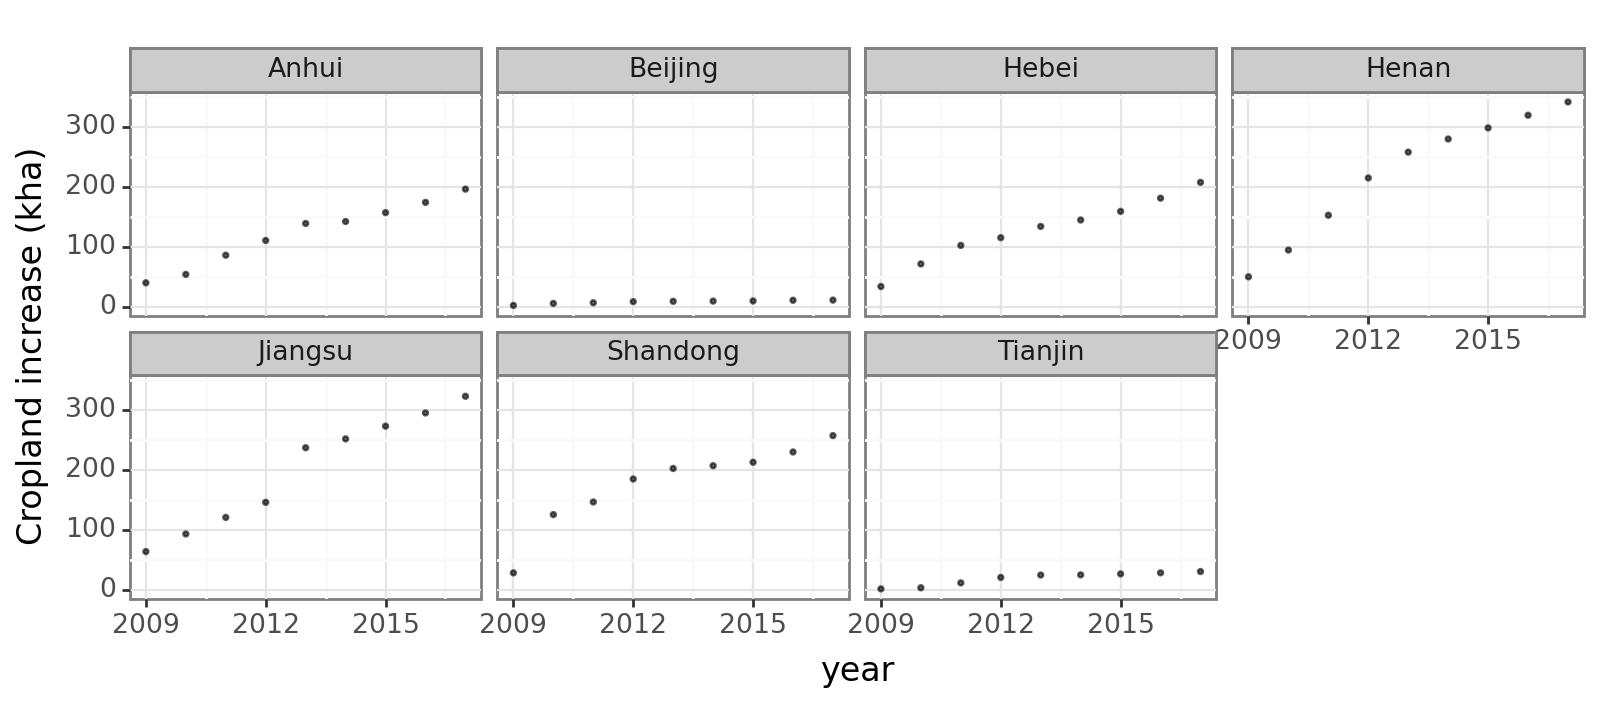

<Figure Size: (800 x 360)>

In [26]:
# plot the area change
plotnine.options.figure_size = (8,3.6)
plotnine.options.dip = 100

(ggplot(cropland_increase_yearbook_NCP)
+ geom_point(aes(x='year',y='yearbook_cumsum_increase_kha'),size=0.5,alpha=0.6)
+ scale_x_continuous(breaks=range(2000,2020,3))
+ facet_wrap('Province',ncol=4)
+ theme_bw(base_size=12)
+ theme(subplots_adjust={'wspace': 0.15})
+ ylab('Cropland increase (kha)')
 )

In [27]:
# get the predictions

pred_dfs = []
for idx,df in cropland_increase_yearbook_NCP.groupby('Province'):

  # get data
  x = df['year']
  y = df['yearbook_cumsum_increase_kha']
  x = sm.add_constant(x)

  # construct the model
  mod = sm.OLS(y, x).fit()

  # make predictions
  pred_df = pd.DataFrame({'year':range(2009,2101)})
  pred_df = sm.add_constant(pred_df)

  rst_invertal = mod.get_prediction(pred_df).summary_frame(alpha=0.05)
  rst_invertal['Province'] = idx
  rst_invertal['year'] = pred_df['year']

  pred_dfs.append(rst_invertal)

# get the pred_df
future_cropland_increase = pd.concat(pred_dfs)

# save to disk
future_cropland_increase.to_csv('./result_csv/future_cropland_increase.csv',index=False)

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


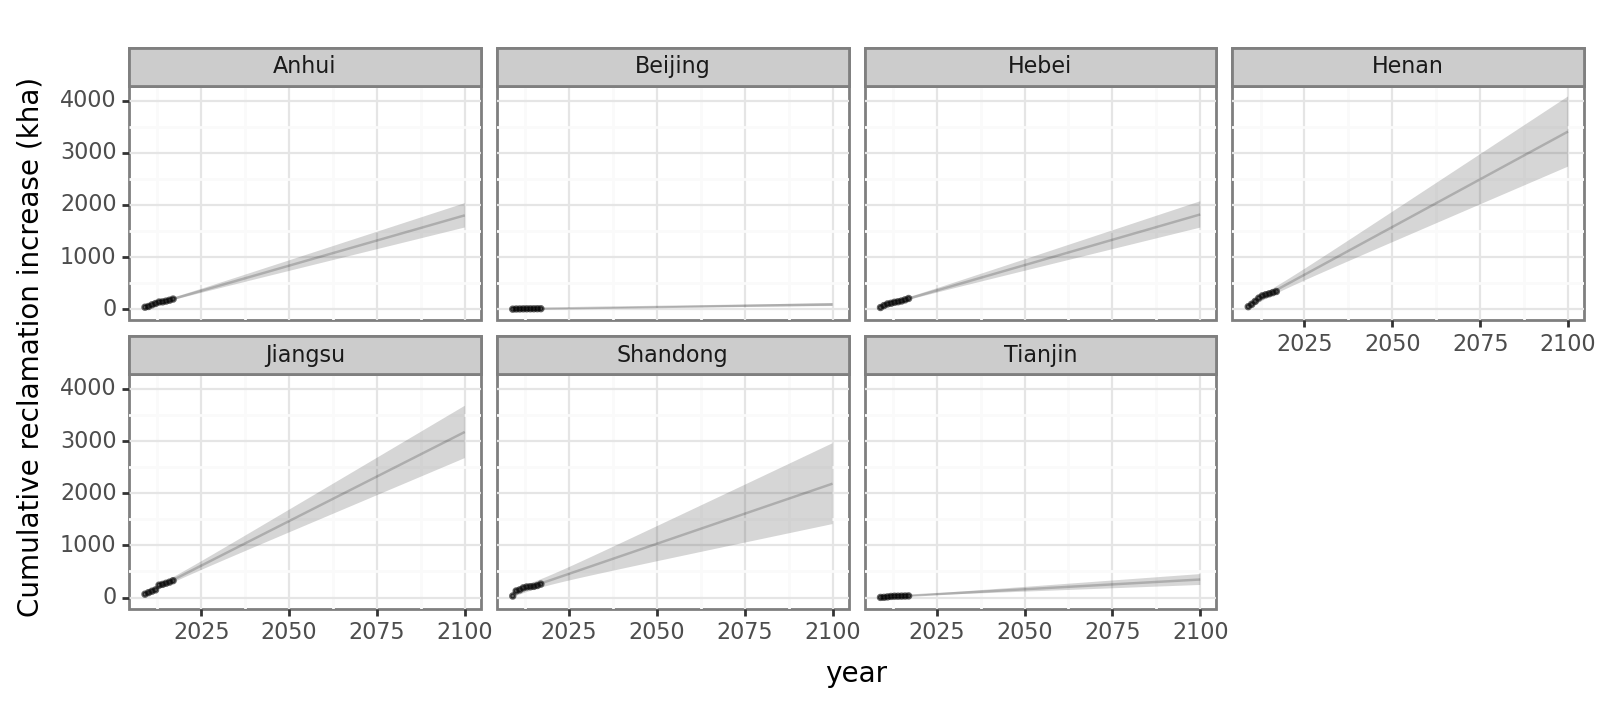

<Figure Size: (800 x 360)>

In [28]:
# plot the area change
plotnine.options.figure_size = (8,3.6)
plotnine.options.dip = 100

g = (ggplot()
+ geom_point(cropland_increase_yearbook_NCP,aes(x='year',y='yearbook_cumsum_increase_kha'),size=0.5,alpha=0.6)
+ geom_line(future_cropland_increase,aes(x='year',y='mean'),size=0.5,alpha=0.2)
+ geom_ribbon(future_cropland_increase,aes(x='year',ymin='obs_ci_lower',ymax='obs_ci_upper'),size=0.5,alpha=0.2)
+ facet_wrap('Province',ncol=4)
+ theme_bw(base_size=10)
+ theme(subplots_adjust={'wspace': 0.15})
+ ylab('Cumulative reclamation increase (kha)')
# + coord_cartesian(xlim = (2009,2100), ylim = (0,1000))
 )

g

In [29]:
g.save('../Figs/sup_8_2_year_fit_reclamation.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 3.6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_8_2_year_fit_reclamation.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


#### 2-3) Compare the reclamation_area with urban_encroachment_area

In [30]:
# read urban_encroach_cropland area df
urban_encroachment_area_df = pd.read_csv('./result_csv/urban_encroachment_area_df.csv') >> mask(X.Scenario != 'SSP4')

# change area from kha to 1000km2
urban_encroachment_area_df[['encroach_area_1000km2_mean','encroach_area_1000km2_top','encroach_area_1000km2_bot']] = \
  urban_encroachment_area_df[['encroach_area_kha_mean','encroach_area_kha_top','encroach_area_kha_bot']] / 100 

# split for plot hist and pred
urban_encroachment_area_df_hist = urban_encroachment_area_df >> mask(X.Scenario == 'Historical')
urban_encroachment_area_df_pred = urban_encroachment_area_df >> mask(X.Scenario != 'Historical')


# get the predicted cropland_area_increase
cropland_increase_hist = cropland_increase_yearbook_NCP.copy()
cropland_increase_hist['color'] = 'Yearbook cropland increase'
cropland_increase_pred = future_cropland_increase >> mask(X.year >= 2018)
cropland_increase_pred['color'] = 'Predict cropland increase'

# change area from kha to 1000km2
cropland_increase_hist['yearbook_cumsum_increase_kha'] = cropland_increase_hist['yearbook_cumsum_increase_kha'] / 100
cropland_increase_pred[['mean','obs_ci_lower','obs_ci_upper']] = \
  cropland_increase_pred[['mean','obs_ci_lower','obs_ci_upper']] / 100

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


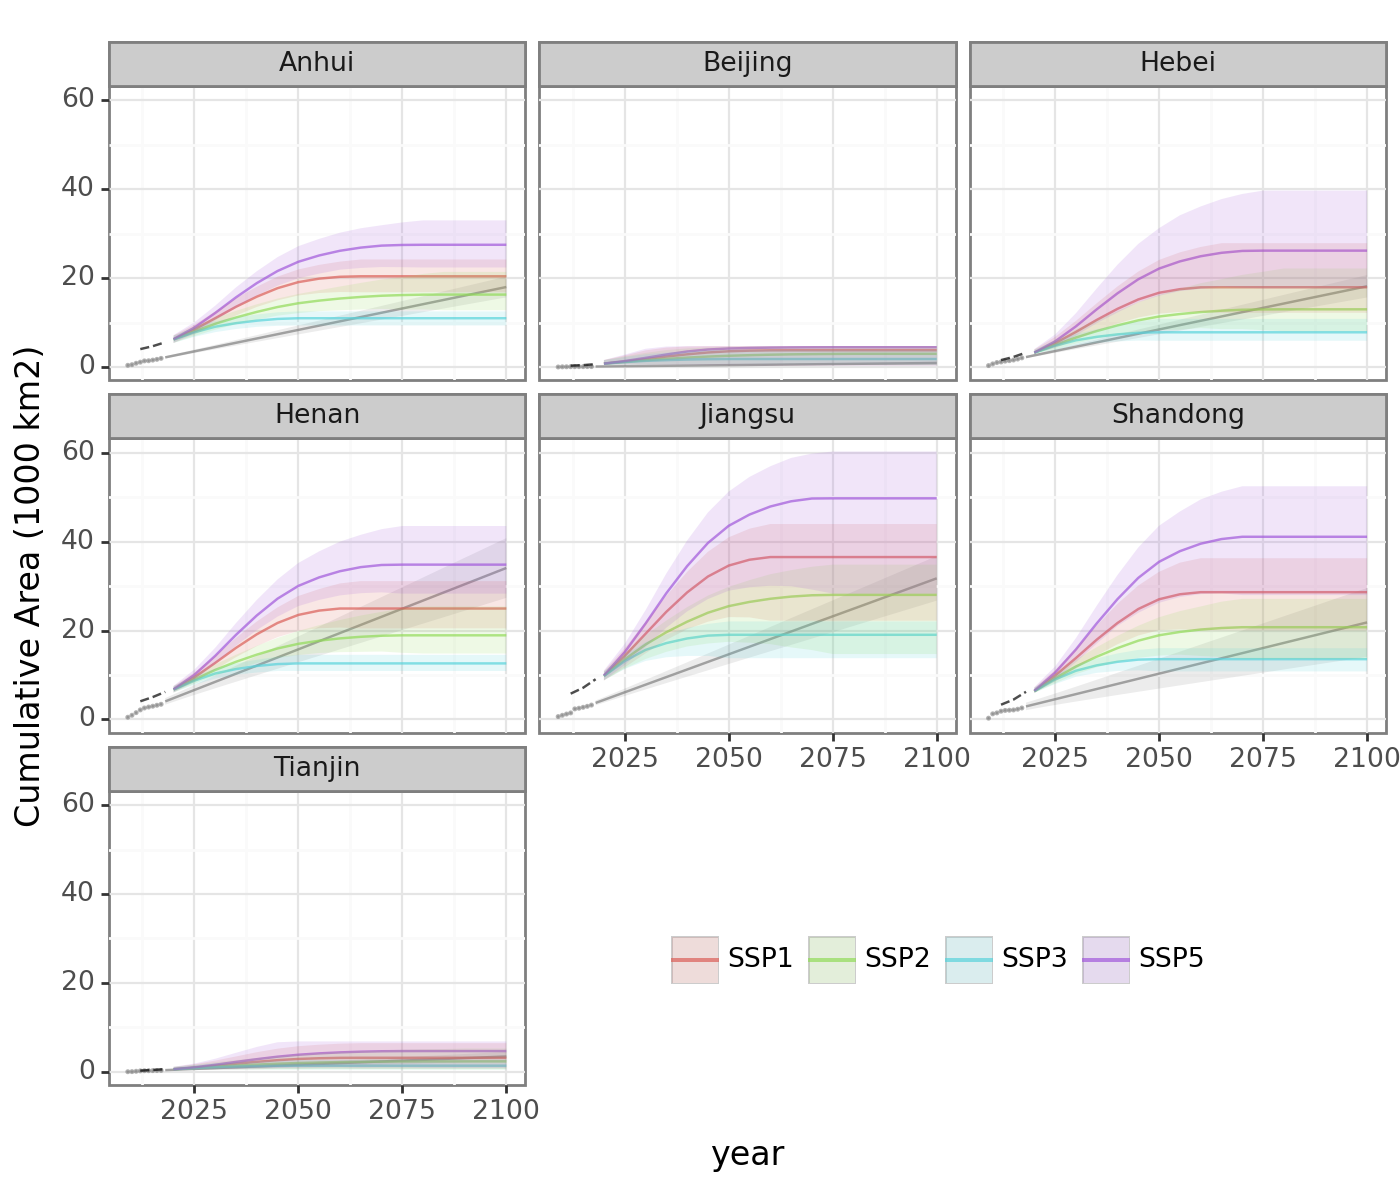

<Figure Size: (700 x 600)>

In [31]:
# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

g = (ggplot()
  # cropland increase hist
  + geom_point(cropland_increase_hist,aes(x='year',y='yearbook_cumsum_increase_kha'),color='grey',size=0.01,alpha=0.6)
  # cropland increase pred
  + geom_line(cropland_increase_pred,aes(x='year',y='mean'),color='grey',size=0.5,alpha=0.7)
  + geom_ribbon(cropland_increase_pred,aes(x='year',ymin='obs_ci_lower',ymax='obs_ci_upper'),fill='grey',size=0.5,alpha=0.15)
  
  # urban excroachment hist
  + geom_line(urban_encroachment_area_df_hist,aes(x='year',y='encroach_area_1000km2_mean'),linetype='dashed',alpha=0.7)
  # urban excroachment pred
  + geom_line(urban_encroachment_area_df_pred,aes(x='year',y='encroach_area_1000km2_mean',color='Scenario'),alpha=0.7)
  + geom_ribbon(urban_encroachment_area_df_pred,aes(x='year',ymin='encroach_area_1000km2_bot',ymax='encroach_area_1000km2_top',
                                fill='Scenario'),alpha=0.15)
  + facet_wrap('Province',ncol=3)
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Cumulative Area (1000 km2)')
  + theme(legend_title=element_blank(),legend_position=(0.67,0.2),legend_background=element_blank())
 )

g

In [32]:
g.save('../Figs/result_2_3_encroach_increase_compare.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_3_encroach_increase_compare.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


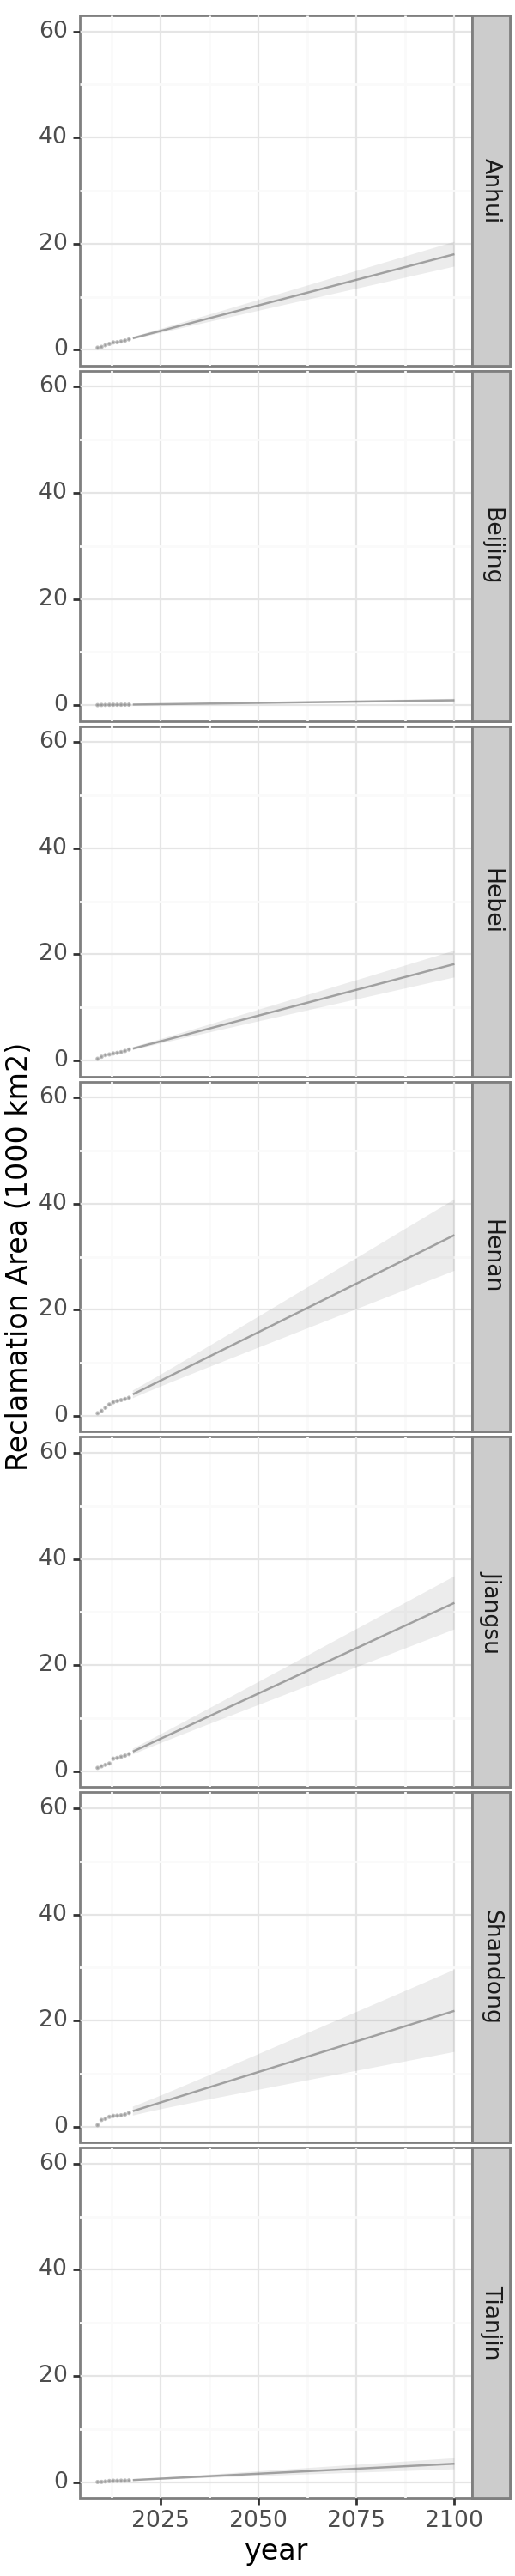

<Figure Size: (300 x 1500)>

In [33]:
# plot the area change
plotnine.options.figure_size = (3,15)
plotnine.options.dip = 100

g = (ggplot()
  # cropland increase hist
  + geom_point(cropland_increase_hist,aes(x='year',y='yearbook_cumsum_increase_kha'),color='grey',size=0.01,alpha=0.5)
  # cropland increase pred
  + geom_line(cropland_increase_pred,aes(x='year',y='mean'),color='grey',size=0.5,alpha=0.7)
  + geom_ribbon(cropland_increase_pred,aes(x='year',ymin='obs_ci_lower',ymax='obs_ci_upper'),fill='grey',size=0.5,alpha=0.15)
  + coord_cartesian(ylim=(0,60))
  # + facet_wrap('Province',ncol=1)
  + facet_grid('Province ~ .')
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Reclamation Area (1000 km2)')
  + theme(legend_title=element_blank(),legend_background=element_blank())
 )

g

In [34]:
g.save('../Figs/result_2_5_1_cropland_gain.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 3 x 15 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_5_1_cropland_gain.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


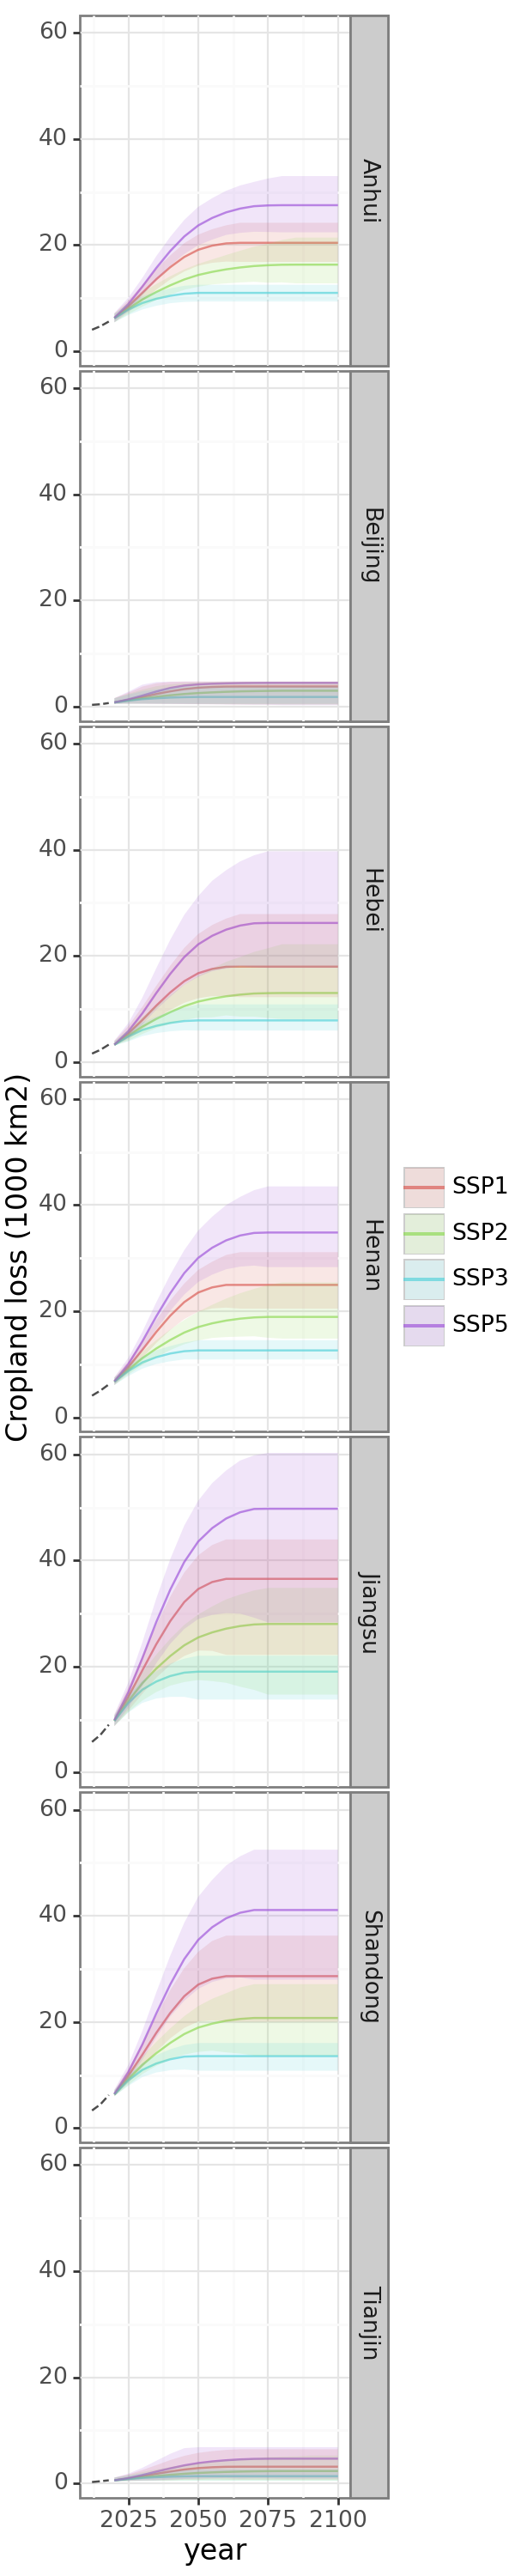

<Figure Size: (300 x 1500)>

In [35]:
# plot the area change
plotnine.options.figure_size = (3,15)
plotnine.options.dip = 100

g = (ggplot() 
  # urban excroachment hist
  + geom_line(urban_encroachment_area_df_hist,aes(x='year',y='encroach_area_1000km2_mean'),linetype='dashed',alpha=0.7)
  # urban excroachment pred
  + geom_line(urban_encroachment_area_df_pred,aes(x='year',y='encroach_area_1000km2_mean',color='Scenario'),alpha=0.7)
  + geom_ribbon(urban_encroachment_area_df_pred,aes(x='year',ymin='encroach_area_1000km2_bot',ymax='encroach_area_1000km2_top',
                                fill='Scenario'),alpha=0.15)
  # + facet_wrap('Province',ncol=1)
  + facet_grid('Province ~ .')
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Cropland loss (1000 km2)')
  + theme(legend_title=element_blank(),legend_background=element_blank())
 )

g

In [36]:
g.save('../Figs/result_2_5_2_cropland_loss.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 3 x 15 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_5_2_cropland_loss.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


In [37]:
# merge cropland_increase with cropland_decrease to compute net cropland change
net_cropland_change = urban_encroachment_area_df.merge(future_cropland_increase)
net_cropland_change = net_cropland_change \
  >> mutate(net_mean = (-X.encroach_area_1000km2_mean + X['mean']/100),
        net_top = (-X.encroach_area_1000km2_bot + X.obs_ci_upper/100),
        net_bot = (-X.encroach_area_1000km2_top + X.obs_ci_lower/100))
  
# seperata data to hist and pred
net_cropland_change_hist = net_cropland_change >> mask(X.Scenario == 'Historical')
net_cropland_change_pred = net_cropland_change >> mask(X.Scenario != 'Historical')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


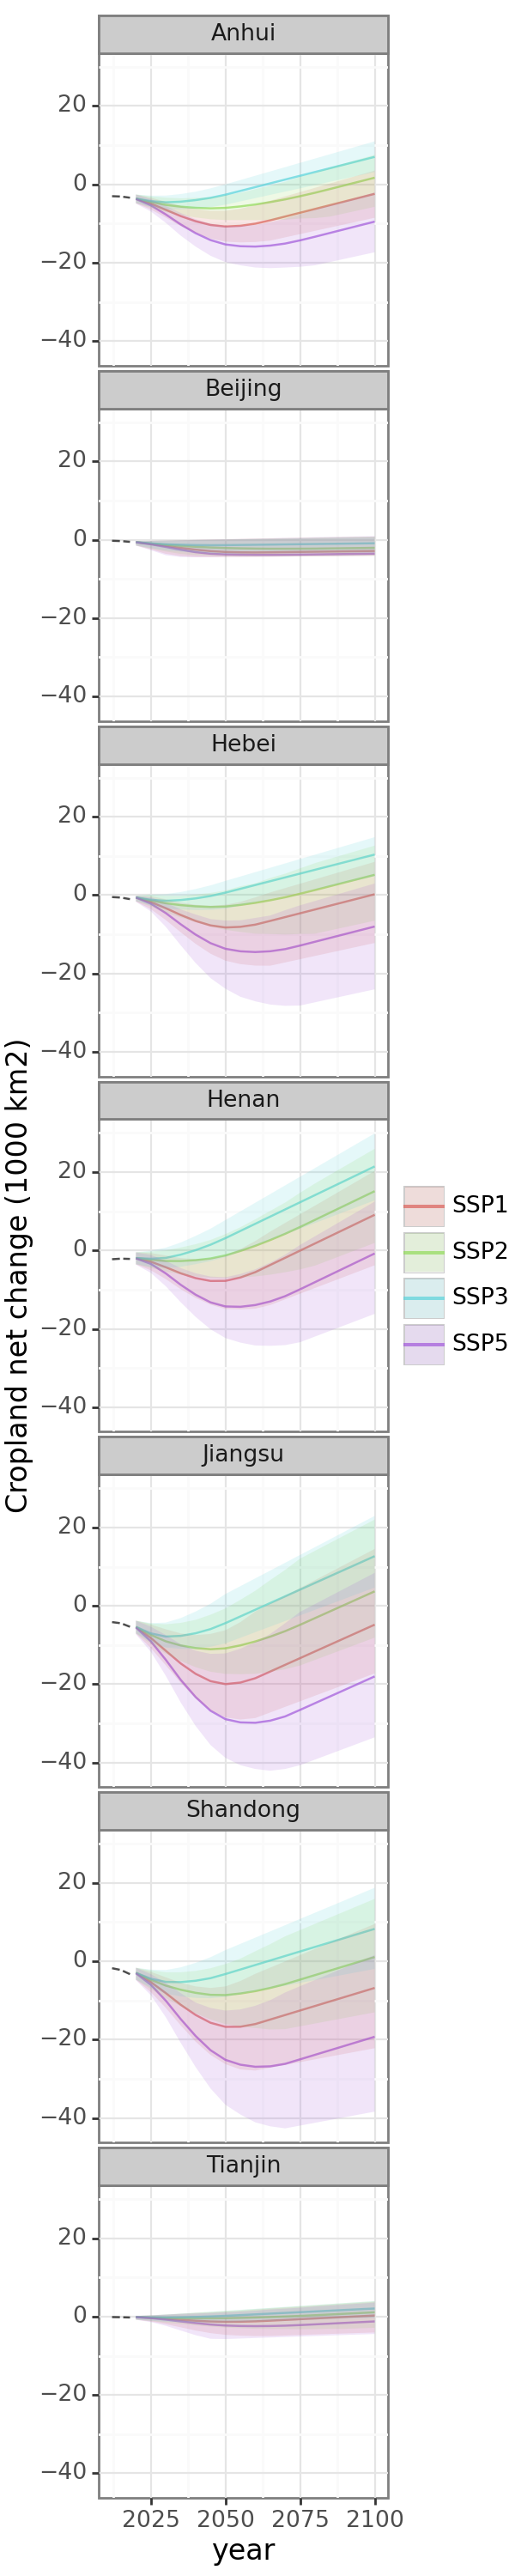

<Figure Size: (300 x 1500)>

In [38]:
# plot the area change
plotnine.options.figure_size = (3,15)
plotnine.options.dip = 100

g = (ggplot() 
  # urban excroachment hist
  + geom_line(net_cropland_change_hist,aes(x='year',y='net_mean'),linetype='dashed',alpha=0.7)
  # urban excroachment pred
  + geom_line(net_cropland_change_pred,aes(x='year',y='net_mean',color='Scenario'),alpha=0.7)
  + geom_ribbon(net_cropland_change_pred,aes(x='year',ymin='net_bot',ymax='net_top',fill='Scenario'),alpha=0.15)
  + facet_wrap('Province',ncol=1)
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Cropland net change (1000 km2)')
  + theme(legend_title=element_blank(),legend_background=element_blank())
 )

g

In [39]:
g.save('../Figs/result_2_5_3_cropland_net_change.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 3 x 15 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_5_3_cropland_net_change.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


#### 2-4) Combine urban encrochment with cropland increase

In [40]:
# get the total yearbook cropland area for each province
yearbook_area_province_sum = yearbook_area.groupby(['Province','year']).sum().reset_index()
yearbook_area_province_sum['area_yearbook_1000km2'] = yearbook_area_province_sum['area_yearbook_kha']/100

yearbook_area_province_sum_2010 = yearbook_area_province_sum >> mask(X.year == 2010) \
                        >> drop(['year']) >> rename(area_yearbook_2010_kha='area_yearbook_kha')

yearbook_area_province_sum_2010['area_yearbook_2010_1000km2'] = yearbook_area_province_sum_2010['area_yearbook_2010_kha']/100

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\4125008863.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [41]:
# link cropland_area_2010, urban_encroachment_area, and future_cropland_increase
final_cropland_area = yearbook_area_province_sum_2010.merge(urban_encroachment_area_df).merge(future_cropland_increase)
final_cropland_area = final_cropland_area \
  >> mutate(final_cropland_area_1000km2 = (X.area_yearbook_2010_1000km2 - X.encroach_area_1000km2_mean + X['mean']/100),
       final_cropland_area_1000km2_top = (X.area_yearbook_2010_1000km2 - X.encroach_area_1000km2_bot + X.obs_ci_upper/100),
       final_cropland_area_1000km2_bot = (X.area_yearbook_2010_1000km2 - X.encroach_area_1000km2_top + X.obs_ci_lower/100))
  
final_cropland_area = final_cropland_area >> select(['Scenario','Province','year','final_cropland_area_1000km2',
                            'final_cropland_area_1000km2_top','final_cropland_area_1000km2_bot'])

In [42]:
# seperate df to hist and pred for ploting
final_cropland_area_hist = final_cropland_area >> mask(X.Scenario == 'Historical') >> drop('Scenario')
final_cropland_area_pred = final_cropland_area >> mask(X.Scenario != 'Historical')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


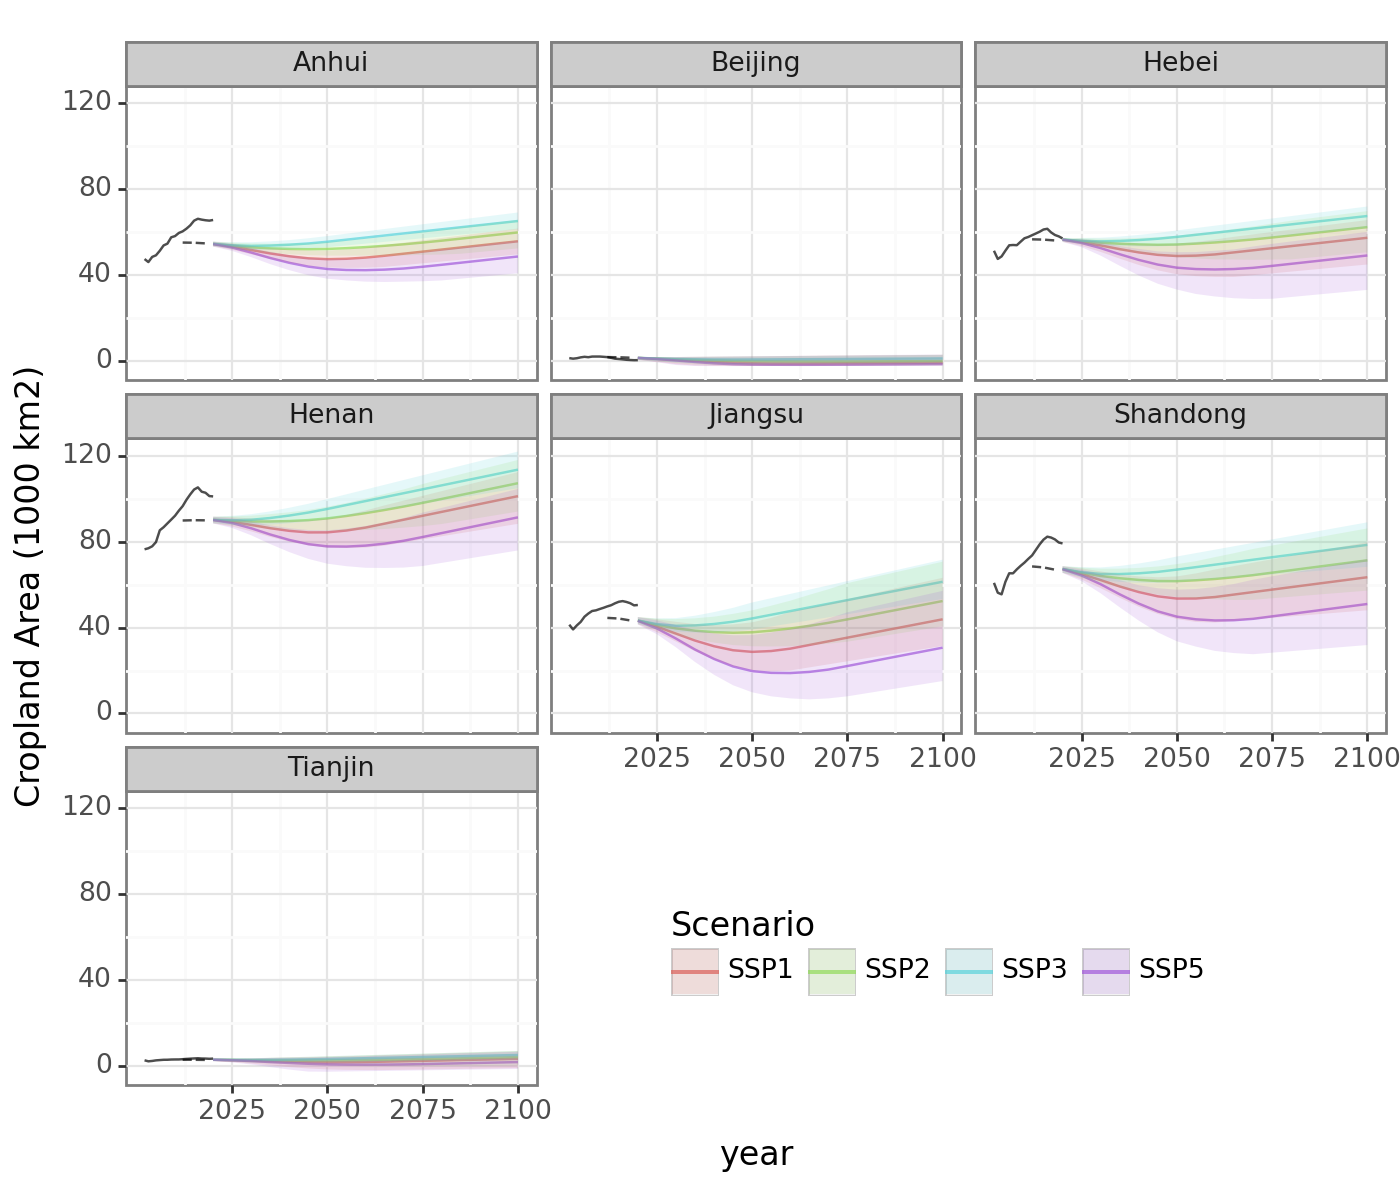

<Figure Size: (700 x 600)>

In [43]:
# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

g = (ggplot()
  # historical cropland
  + geom_line(yearbook_area_province_sum,aes(x='year',y='area_yearbook_1000km2'),alpha=0.7)
  # urban excroachment hist
  + geom_line(final_cropland_area_hist,aes(x='year',y='final_cropland_area_1000km2'),alpha=0.7,linetype='dashed')
  # urban excroachment pred
  + geom_line(final_cropland_area_pred,aes(x='year',y='final_cropland_area_1000km2',color='Scenario'),alpha=0.7)
  + geom_ribbon(final_cropland_area_pred,
        aes(x='year',ymin='final_cropland_area_1000km2_bot',ymax='final_cropland_area_1000km2_top',fill='Scenario'),alpha=0.15)
  + scale_x_continuous(breaks = range(2025,2101,25))
  + facet_wrap(['Province'],ncol=3)
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1},legend_position=(0.67,0.21))
  + ylab('Cropland Area (1000 km2)')
 )

g

In [44]:
g.save('../Figs/result_2_4_final_cropland_area.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_4_final_cropland_area.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


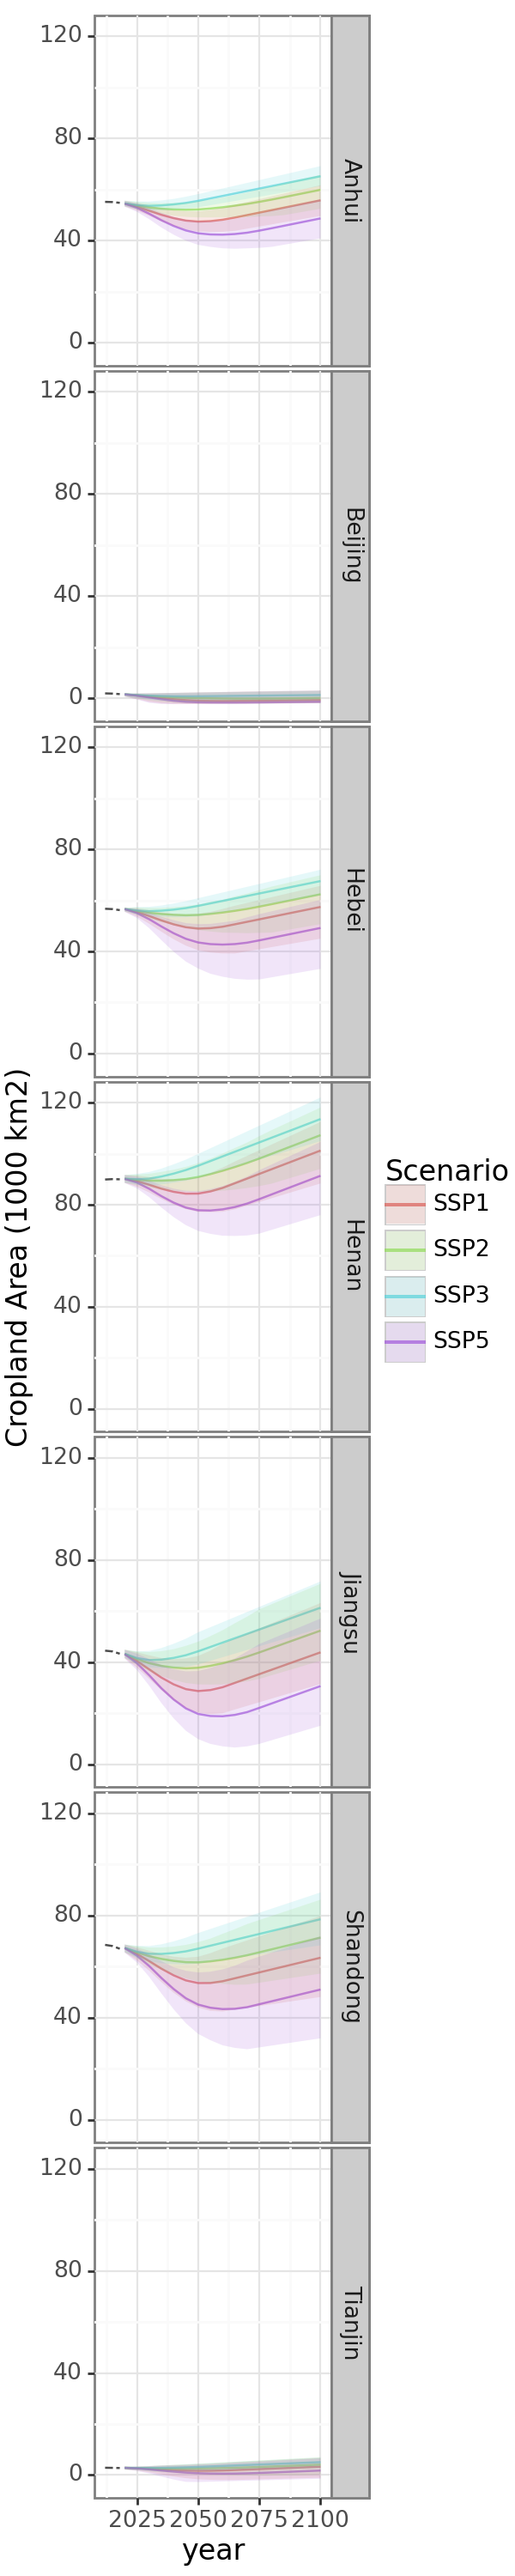

<Figure Size: (300 x 1500)>

In [45]:
# plot the area change
plotnine.options.figure_size = (3,15)
plotnine.options.dip = 100

g = (ggplot()
  # # historical cropland
  # + geom_line(yearbook_area_province_sum,aes(x='year',y='area_yearbook_1000km2'),alpha=0.7)
  # urban excroachment hist
  + geom_line(final_cropland_area_hist,aes(x='year',y='final_cropland_area_1000km2'),alpha=0.7,linetype='dashed')
  # urban excroachment pred
  + geom_line(final_cropland_area_pred,aes(x='year',y='final_cropland_area_1000km2',color='Scenario'),alpha=0.7)
  + geom_ribbon(final_cropland_area_pred,
        aes(x='year',ymin='final_cropland_area_1000km2_bot',ymax='final_cropland_area_1000km2_top',fill='Scenario'),alpha=0.15)
  + scale_x_continuous(breaks = range(2025,2101,25))
  # + facet_wrap(['Province'],ncol=1)
  + facet_grid('Province ~ .')
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Cropland Area (1000 km2)')
 )

g

In [46]:
g.save('../Figs/result_2_5_4_cropland_final.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 3 x 15 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_5_4_cropland_final.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\3288960674.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\3288960674.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\3288960674.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


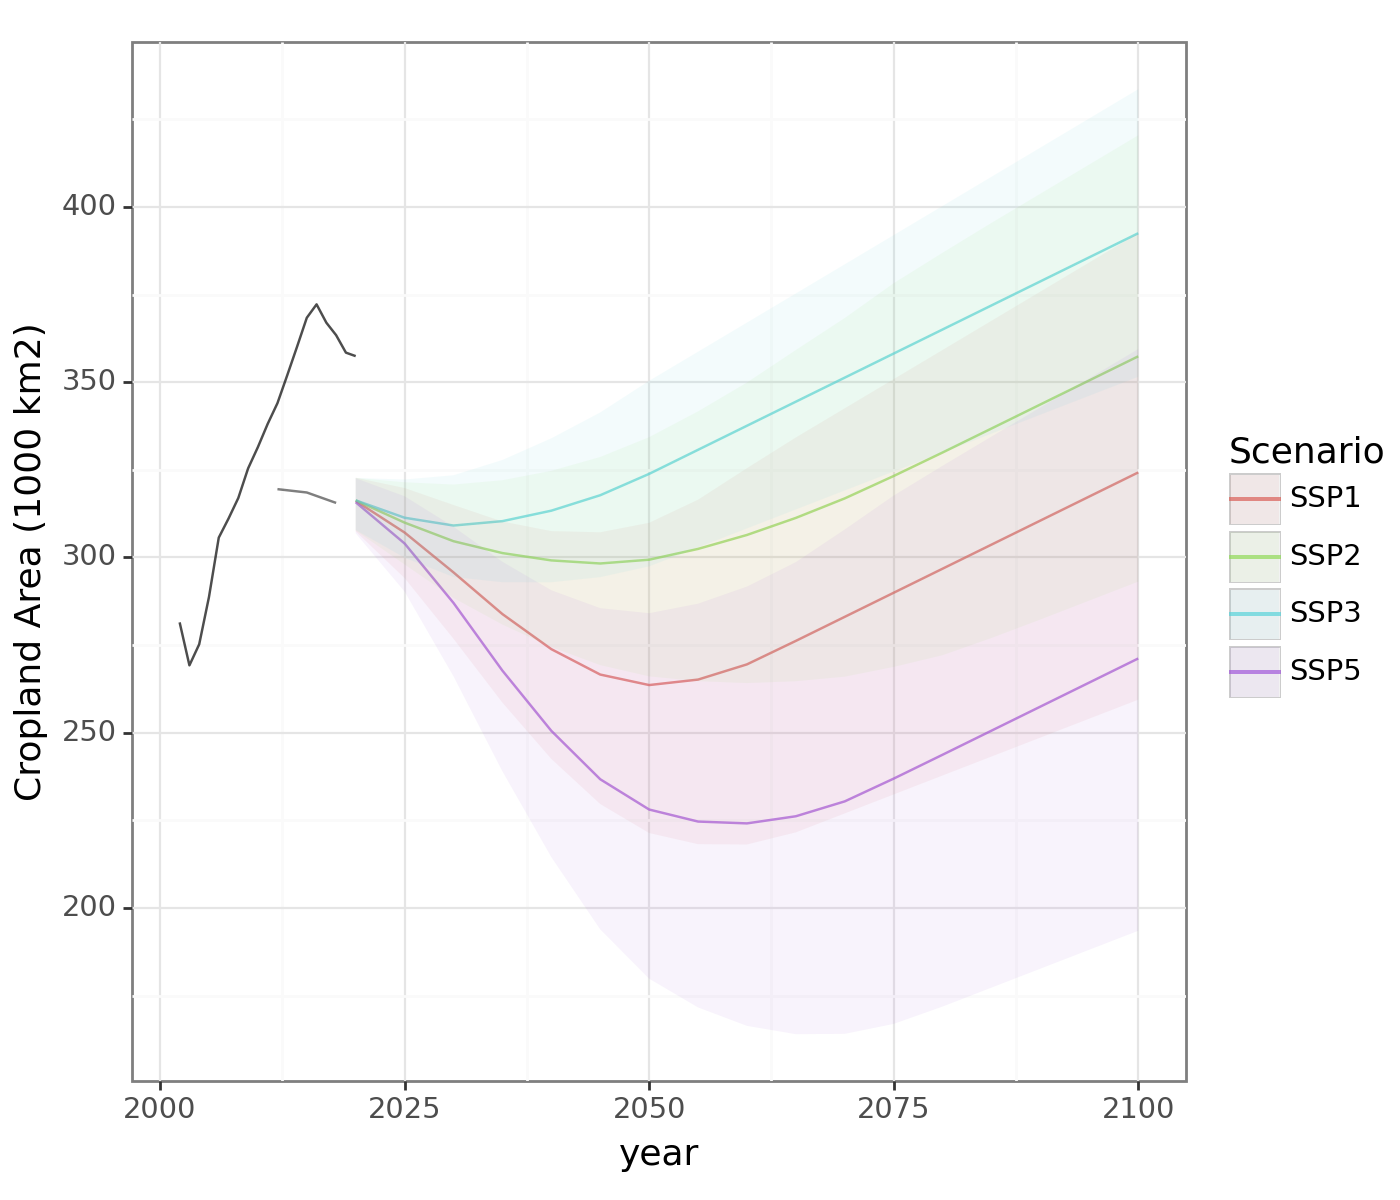

<Figure Size: (700 x 600)>

In [47]:
# compute the total change
final_cropland_area_hist_sum = final_cropland_area_hist.groupby(['year']).sum().reset_index()
final_cropland_area_pred_sum = final_cropland_area_pred.groupby(['Scenario','year']).sum().reset_index()

yearbook_area_province_sum_total = yearbook_area_province_sum.groupby('year').sum().reset_index()

# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

(ggplot()
# historical cropland
+ geom_line(yearbook_area_province_sum_total,aes(x='year',y='area_yearbook_1000km2'),alpha=0.7)
# urban excroachment pred
+ geom_line(final_cropland_area_hist_sum,aes(x='year',y='final_cropland_area_1000km2'),alpha=0.5)
# urban excroachment pred
+ geom_line(final_cropland_area_pred_sum,
            aes(x='year',y='final_cropland_area_1000km2',color='Scenario'),alpha=0.7)
+ geom_ribbon(final_cropland_area_pred_sum,
       aes(x='year',ymin='final_cropland_area_1000km2_bot',ymax='final_cropland_area_1000km2_top',fill='Scenario'),alpha=0.07)
# + facet_wrap(['Province'],ncol=3)
# + scale_x_continuous(breaks=range(2000,2101,10))
+ theme_bw(base_size=13)
+ ylab('Cropland Area (1000 km2)')
 )

#### 2-5) the stopping point of cropland_area increase

- The cropland increase will not stop because the sum of future_cropland and future_urban can't reach the total area of historical sum_urban_cropland

In [48]:
# 1) get the future urban area
future_pred_area = pd.read_csv('./result_csv/future_pred_area.csv') >> rename(Scenario='ssp')
future_pred_area.head()

,Province,area_1000_km2,area_1000_km2_bot,area_1000_km2_top,year,Scenario
0,Shandong,67.569682,79.738186,53.397334,2065,SSP5
1,Henan,51.638177,59.678525,45.157477,2065,SSP5
2,Beijing,9.145417,16.319238,1.155523,2065,SSP5
3,Tianjin,8.437095,11.641531,3.363123,2065,SSP5
4,Hebei,45.119459,59.941072,35.982742,2065,SSP5


In [49]:
# 2) the future cropland area
final_cropland_area_pred.head()

,Scenario,Province,year,final_cropland_area_1000km2,final_cropland_area_1000km2_top,final_cropland_area_1000km2_bot
0,SSP5,Anhui,2085,45.820235,52.869141,38.395280
1,SSP1,Anhui,2085,52.910094,58.444545,47.194156
2,SSP2,Anhui,2085,57.029188,62.489003,49.992815
3,SSP3,Anhui,2085,62.346525,65.913377,58.876326
4,SSP5,Anhui,2090,46.785349,53.967011,39.227639


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\3228399692.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


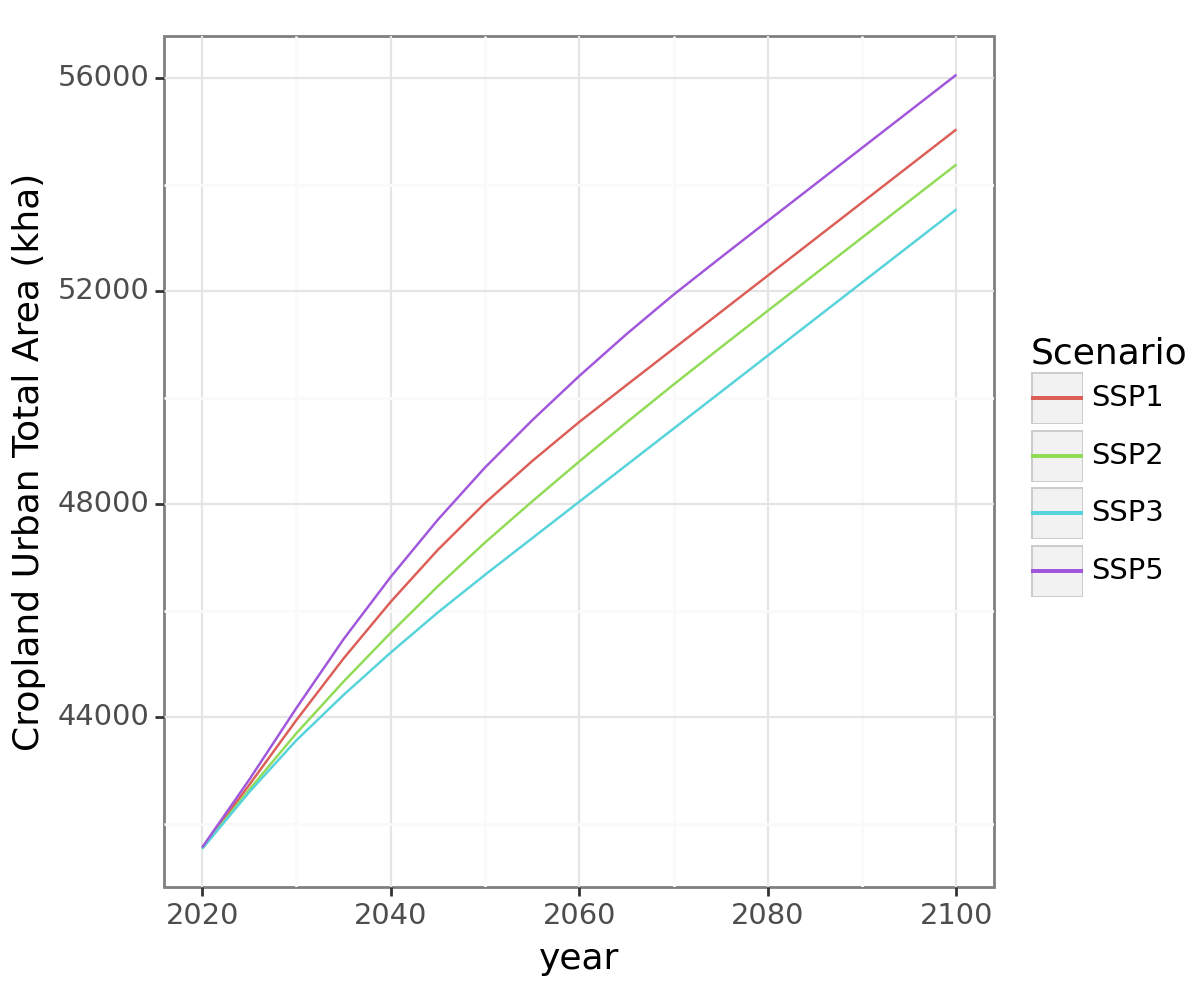

<Figure Size: (600 x 500)>

In [50]:
# 3) future cropland_&_urban area
future_crop_and_urban_area = final_cropland_area_pred.merge(future_pred_area)
future_crop_and_urban_area.head()

# 4) urban_cropland_sum
future_crop_and_urban_area = future_crop_and_urban_area \
                >> mutate(urban_cropland_sum_kha = (X.final_cropland_area_1000km2)*100 + (X.area_1000_km2)*100)

future_crop_and_urban_area_sum = future_crop_and_urban_area.groupby(['Scenario','year']).sum().reset_index()

# 5) plot the urban_cropland_sum
plotnine.options.figure_size = (6,5)
plotnine.options.dip = 100

# plot the trend
(ggplot()
 # total area of this study
 + geom_line(future_crop_and_urban_area_sum,aes(x='year',y='urban_cropland_sum_kha',color='Scenario'))
 + theme_bw(base_size=13)
 + ylab('Cropland Urban Total Area (kha)')
)

In [51]:
# get the lucc img df
LUCC_NCP_df = pd.DataFrame({k:[v] for k,v in LUCC_NCP.items()}).T.reset_index()
LUCC_NCP_df.columns = ['year','lucc_img']

NCP_urban_df = pd.DataFrame({yr:[NCP_urban_maps.gte(val)] for yr,val in year_val_code}).T.reset_index()
NCP_urban_df.columns = ['year','urban_img']

# combine lucc_img with NCP_urban_img
lucc_with_urban = LUCC_NCP_df.merge(NCP_urban_df)

In [52]:
# compute the total area of urban(8) and cropland(1)
def compute_total_area(in_df):
  print(' ',end='',flush=True)

  df_list = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    in_img = row['lucc_img'].eq(1).Or(row['lucc_img'].eq(8))
    area_img = ee.Image.pixelArea().updateMask(in_img)

    stats = area_img.reduceRegions(collection=NCP_shp,scale=30,reducer='sum').getInfo()

    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] for i in stats['features']}).T.reset_index()
    stats_df.columns = ['Province','area_m2']

    stats_df['area_kha'] = stats_df['area_m2']/10000/1000
    stats_df['year'] = row['year']

    df_list.append(stats_df)

  return pd.concat(df_list).reset_index(drop=True)

# get the total arae of cropland and urban for lucc
lucc_cropland_urban_province_sum = parallelize_dataframe(LUCC_NCP_df,compute_total_area,15).reset_index(drop=True)
lucc_cropland_urban_sum = lucc_cropland_urban_province_sum.groupby('year').sum().reset_index()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\751434771.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


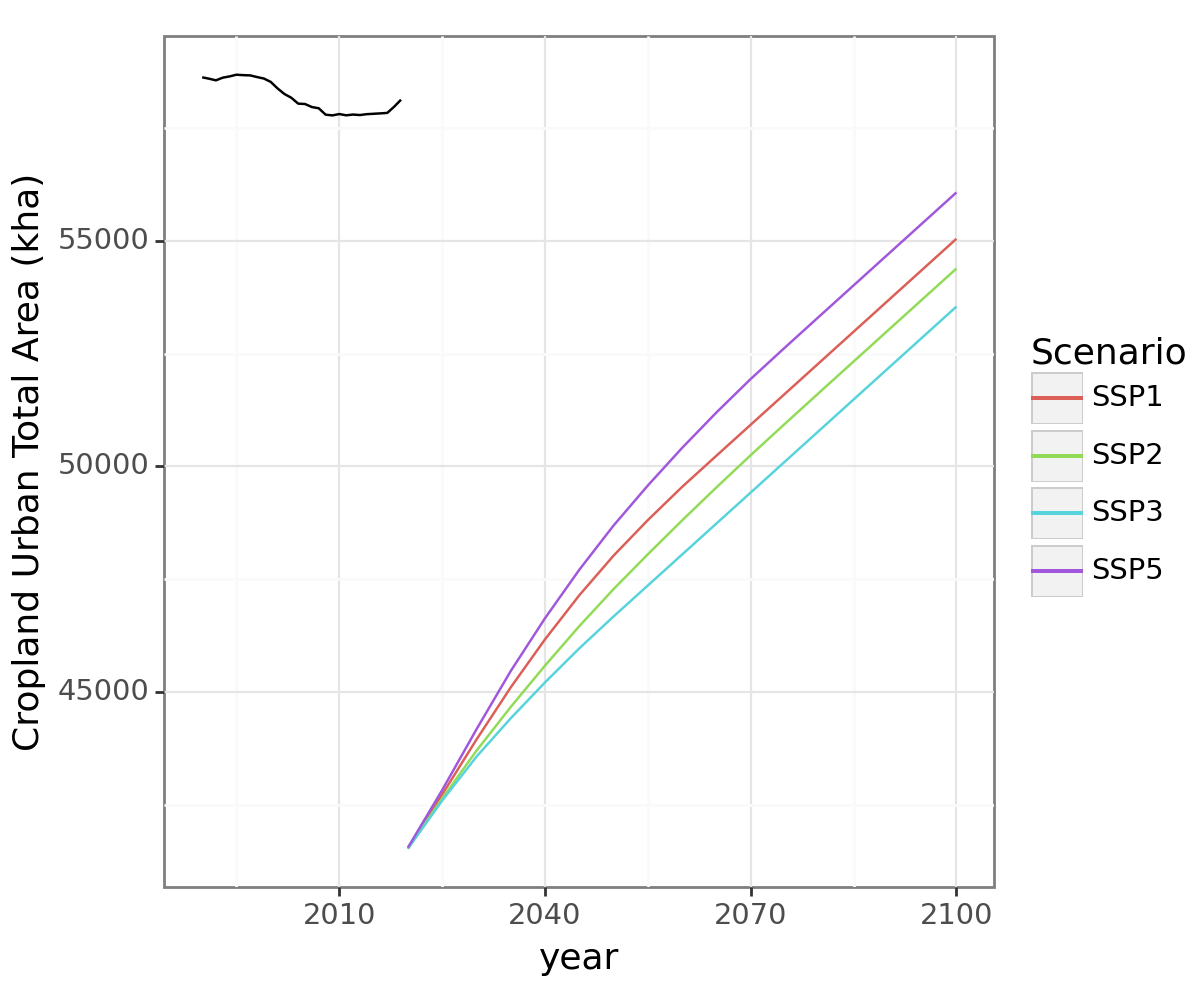

<Figure Size: (600 x 500)>

In [53]:
# 6) plot the urban_cropland_sum
plotnine.options.figure_size = (6,5)
plotnine.options.dip = 100

# plot the trend
g = (ggplot()
 # total area of this study
 + geom_line(future_crop_and_urban_area_sum,aes(x='year',y='urban_cropland_sum_kha',color='Scenario'))
 + geom_line(lucc_cropland_urban_sum,aes(x='year',y='area_kha'))
 + theme_bw(base_size=13)
 + ylab('Cropland Urban Total Area (kha)')
)

g

In [55]:
g.save('../Figs/sup_9_sum_of_urban_cropland.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_9_sum_of_urban_cropland.svg


### 3) convert cropland_increase to imgs

#### 3-1) determine the area ratio for each crop/water in every province
- The cropland increase record is a single value for each province
- So, so we need to distribute this value to each pixel for the crop/water layer

In [56]:
# compute the total cropland area (crop/water) for each province
total_cropland_area_img = ee.ImageCollection([ee.Image(i).unmask() for i in GAEZ_cropland_2010_corrected['GEE_path']]).sum()
total_cropland_area_stats = total_cropland_area_img.reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()
total_cropland_area_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] \
                      for i in total_cropland_area_stats['features']}).T.reset_index()

total_cropland_area_df.columns = ['Province','total_cropland_area_kha']                   

In [57]:
# compute the cropland area for each crop/water at every province
area_dfs = []
for idx,row in tqdm(GAEZ_cropland_2010_corrected.iterrows(),total=len(GAEZ_cropland_2010_corrected)):
  crop = row['crop']
  water = row['water']
  img = ee.Image(row['GEE_path']).unmask()

  area_stats = img.reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()
  area_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] \
                  for i in area_stats['features']}).T.reset_index()

  area_df.columns = ['Province','cropland_area_kha']

  area_df['crop'] = crop
  area_df['water'] = water

  area_dfs.append(area_df)

# concat all dfs to one df
area_df_crop_water = pd.concat(area_dfs).reset_index(drop=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [58]:
# merge all_area with each_crop_area to compute the cropland_area ratio
cropland_area_ratio = area_df_crop_water.merge(total_cropland_area_df)
cropland_area_ratio['total_area_ratio'] = cropland_area_ratio['cropland_area_kha']/cropland_area_ratio['total_cropland_area_kha']
cropland_area_ratio.head(6)

,Province,cropland_area_kha,crop,water,total_cropland_area_kha,total_area_ratio
0,Shandong,3181.254272,Maize,Irrigated,7399.51265,0.429928
1,Shandong,713.250926,Maize,Rainfed,7399.51265,0.096392
2,Shandong,166.623984,Wetland_rice,Irrigated,7399.51265,0.022518
3,Shandong,0.000000,Wetland_rice,Rainfed,7399.51265,0.000000
4,Shandong,3052.060039,Wheat,Irrigated,7399.51265,0.412468
5,Shandong,286.323429,Wheat,Rainfed,7399.51265,0.038695


#### 3-2) seperate the reclamation_area to each crop/water at every province

In [59]:
# compute the reclamation_area for each crop/water/province/year
reclamation_with_total_area_ratio = cropland_area_ratio.merge(future_cropland_increase)

# compute the cropland_increase for each province                  
reclamation_with_total_area_ratio['reclamation_increase_kha'] = reclamation_with_total_area_ratio['mean']\
                                    * reclamation_with_total_area_ratio['total_area_ratio']
reclamation_with_total_area_ratio['reclamation_increase_kha_bot'] = reclamation_with_total_area_ratio['obs_ci_lower']\
                                    * reclamation_with_total_area_ratio['total_area_ratio']
reclamation_with_total_area_ratio['reclamation_increase_kha_top'] = reclamation_with_total_area_ratio['obs_ci_upper']\
                                    * reclamation_with_total_area_ratio['total_area_ratio']

# select only necessary cols
reclamation_with_total_area_ratio = reclamation_with_total_area_ratio >> \
                    select(['Province','year','crop','water','reclamation_increase_kha',
                        'reclamation_increase_kha_bot','reclamation_increase_kha_top'])
reclamation_with_total_area_ratio

,Province,year,crop,water,reclamation_increase_kha,reclamation_increase_kha_bot,reclamation_increase_kha_top
0,Shandong,2009,Maize,Irrigated,36.666820,2.010878,71.322762
1,Shandong,2010,Maize,Irrigated,46.576876,13.420673,79.733079
2,Shandong,2011,Maize,Irrigated,56.486932,24.444919,88.528945
3,Shandong,2012,Maize,Irrigated,66.396987,35.042487,97.751488
4,Shandong,2013,Maize,Irrigated,76.307043,45.185089,107.428998
...,...,...,...,...,...,...,...
3859,Jiangsu,2096,Wheat,Rainfed,100.560756,84.715883,116.405628
3860,Jiangsu,2097,Wheat,Rainfed,101.692281,85.658326,117.726237
3861,Jiangsu,2098,Wheat,Rainfed,102.823807,86.600747,119.046867
3862,Jiangsu,2099,Wheat,Rainfed,103.955332,87.543148,120.367517


In [60]:
# compute the pix_count for each crop/water, based on the cropland area of 2010
pix_count = []
for idx,row in tqdm(GAEZ_cropland_2010_corrected.iterrows(),total=len(GAEZ_cropland_2010_corrected)):
  crop = row['crop']
  water = row['water']
  crop_area_img = ee.Image(row['GEE_path'])

  stats = ee.Image(1).updateMask(crop_area_img.gt(0))\
        .reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()

  pix_count_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] 
                        for i in stats['features']}).T.reset_index()
                        
  pix_count_df.columns = ['Province','count']

  pix_count_df['crop'] = crop
  pix_count_df['water'] = water

  pix_count.append(pix_count_df)

# concat all dfs to one
pix_count_all = pd.concat(pix_count).reset_index(drop=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [61]:
# link the increase_area with pix_count
reclamation_each_pix = reclamation_with_total_area_ratio.merge(pix_count_all)
reclamation_each_pix['pix_increase_kha'] = reclamation_each_pix['reclamation_increase_kha']/reclamation_each_pix['count']
reclamation_each_pix['pix_increase_kha_bot'] = reclamation_each_pix['reclamation_increase_kha_bot']/reclamation_each_pix['count']
reclamation_each_pix['pix_increase_kha_top'] = reclamation_each_pix['reclamation_increase_kha_top']/reclamation_each_pix['count']

# convert Nan to 0
reclamation_each_pix = reclamation_each_pix.replace({np.nan:0})

# convert pix_increase value to imgs
reclamation_each_pix = reclamation_each_pix.merge(GAEZ_cropland_2010_corrected)
reclamation_each_pix['region_shp'] = NCP_shp

reclamation_each_pix['pix_increase_kha_img'] = reclamation_each_pix.apply(lambda row:ee.Image(row['GEE_path'])
                                .clip(row['region_shp'].filter(ee.Filter.eq('EN_Name',row['Province'])))
                                .multiply(0).add(row['pix_increase_kha']),1)
reclamation_each_pix['pix_increase_kha_img_bot'] = reclamation_each_pix.apply(lambda row:ee.Image(row['GEE_path'])
                                .clip(row['region_shp'].filter(ee.Filter.eq('EN_Name',row['Province'])))
                                .multiply(0).add(row['pix_increase_kha_bot']),1)
reclamation_each_pix['pix_increase_kha_img_top'] = reclamation_each_pix.apply(lambda row:ee.Image(row['GEE_path'])
                                .clip(row['region_shp'].filter(ee.Filter.eq('EN_Name',row['Province'])))
                                .multiply(0).add(row['pix_increase_kha_top']),1)

# select only necessary cols
reclamation_each_pix = reclamation_each_pix >> drop(['count','region_shp','reclamation_increase_kha',
                            'reclamation_increase_kha_bot','reclamation_increase_kha_top',
                            'pix_increase_kha','pix_increase_kha_bot','pix_increase_kha_top',	
                            'theme','variable','time','GEE_path'])

In [62]:
# mosaic the crop/water/year of the same year into a single img
reclamation_each_pix_mosaic = reclamation_each_pix.groupby(['crop','water','year'])\
                .apply(lambda df: [ee.ImageCollection(df['pix_increase_kha_img'].tolist()).mosaic(),
                           ee.ImageCollection(df['pix_increase_kha_img_bot'].tolist()).mosaic(),
                           ee.ImageCollection(df['pix_increase_kha_img_top'].tolist()).mosaic()])\
                .reset_index()

reclamation_each_pix_mosaic['pix_increase_kha_img'] = reclamation_each_pix_mosaic[0].apply(lambda x:x[0])
reclamation_each_pix_mosaic['pix_increase_kha_img_bot'] = reclamation_each_pix_mosaic[0].apply(lambda x:x[1])
reclamation_each_pix_mosaic['pix_increase_kha_img_top'] = reclamation_each_pix_mosaic[0].apply(lambda x:x[2])

reclamation_each_pix_mosaic = reclamation_each_pix_mosaic.drop([0],1)

# save to disk
reclamation_each_pix_mosaic.to_pickle('./result_csv/reclamation_each_pix_mosaic.pkl')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\1211258792.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


#### 3-3) validata the reclamation_img stats is the same as the future_cropland_increase

In [63]:
# remove historical imgs
reclamation_each_pix_mosaic_sum = reclamation_each_pix_mosaic.copy()

# get the sum of all reclamation imgs
reclamation_each_pix_mosaic_sum = reclamation_each_pix_mosaic_sum.groupby(['year'])\
            .apply(lambda df:[ee.ImageCollection([img for img in df['pix_increase_kha_img'].tolist()]).sum(),
                    ee.ImageCollection([img for img in df['pix_increase_kha_img_top'].tolist()]).sum(),
                    ee.ImageCollection([img for img in df['pix_increase_kha_img_bot'].tolist()]).sum()])\
            .reset_index()

# get the mean/top/bot imgs
reclamation_each_pix_mosaic_sum = reclamation_each_pix_mosaic_sum.rename({0:'imgs'}, axis=1)
reclamation_each_pix_mosaic_sum['reclamation_sum_img'] = reclamation_each_pix_mosaic_sum['imgs'].apply(lambda row:row[0])
reclamation_each_pix_mosaic_sum['reclamation_sum_img_top'] = reclamation_each_pix_mosaic_sum['imgs'].apply(lambda row:row[1])
reclamation_each_pix_mosaic_sum['reclamation_sum_img_bot'] = reclamation_each_pix_mosaic_sum['imgs'].apply(lambda row:row[2])

reclamation_each_pix_mosaic_sum = reclamation_each_pix_mosaic_sum >> drop('imgs')

In [64]:
# function to compute sum
def get_sum(in_df):
  print(' ',end='',flush=True)

  out_dfs=[]

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    # get properties
    year = row['year']
    in_img = ee.Image([row['reclamation_sum_img'],row['reclamation_sum_img_top'],row['reclamation_sum_img_bot']])

    # compute the area of the input img
    stats = in_img.reduceRegions(collection=NCP_shp,
                    scale=GAEZ_pix_scale,
                    reducer=ee.Reducer.sum().repeat(3)).getInfo()

    # contructe the stats_df
    stats_data = pd.DataFrame({i['properties']['EN_Name']:i['properties']['sum'] 
                    for i in stats['features']}).T.reset_index()

    stats_data.columns = ['Province','area_kha','area_kha_top','area_kha_bot']
    stats_data['year'] = year

    out_dfs.append(stats_data)

  return pd.concat(out_dfs)


In [66]:
# # get the reclamation area from the reclamation_imgs
# cropland_increase_df = parallelize_dataframe(reclamation_each_pix_mosaic_sum,get_sum,20)

# # save to disk
# cropland_increase_df.to_csv('./result_csv/cropland_increase_df.csv',index=False)

# read data
cropland_increase_df = pd.read_csv('./result_csv/cropland_increase_df.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [67]:
# get the validation df
df_validate = cropland_increase_df.merge(future_cropland_increase)
df_validate['rate'] = df_validate['area_kha'] / df_validate['mean']

# plot the ratio between area of reclmation_img and reclamation_df
sns.distplot(df_validate['rate'])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12828\1628309649.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='rate', ylabel='Density'>

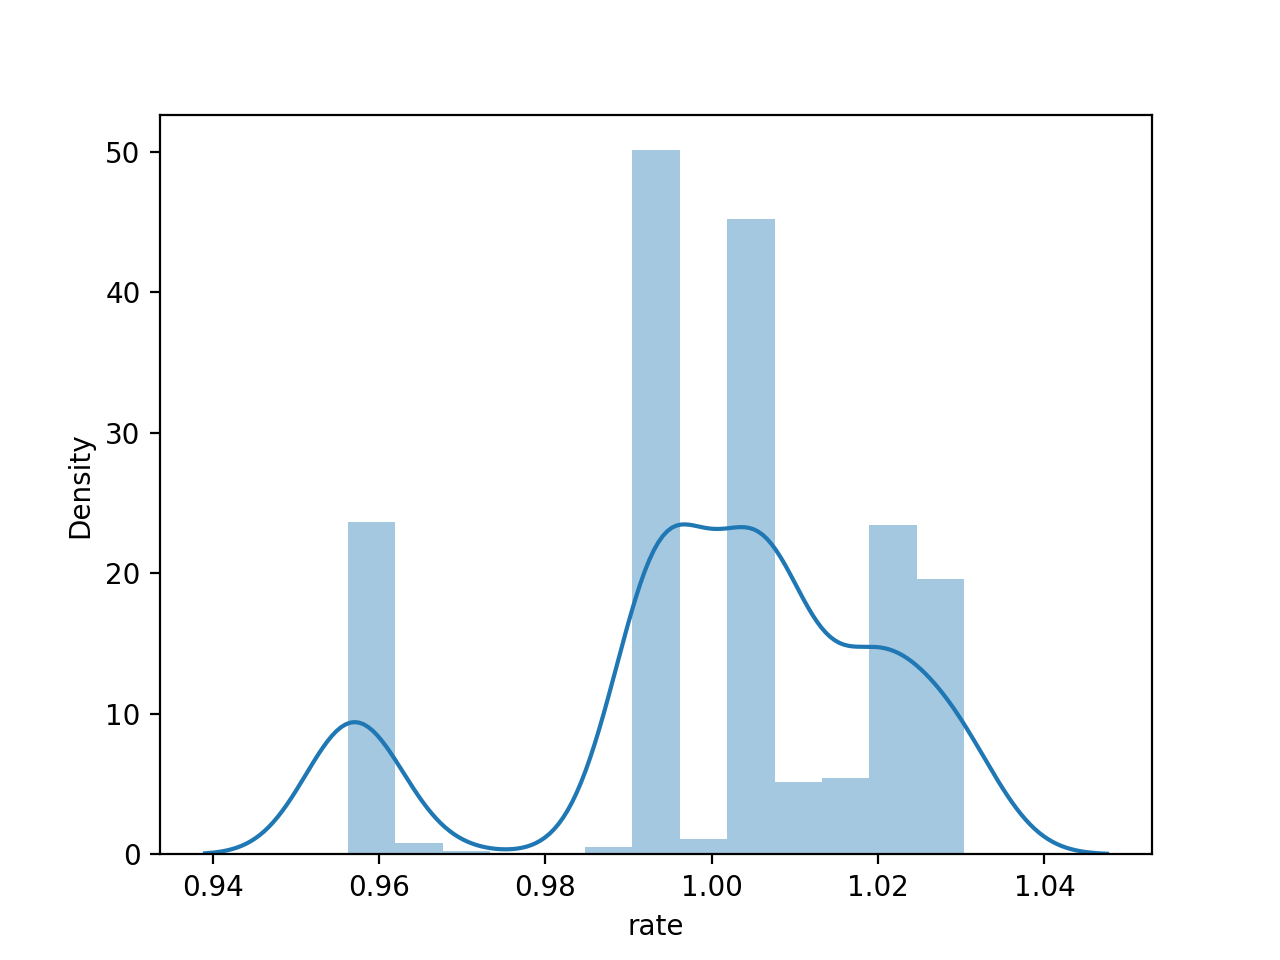

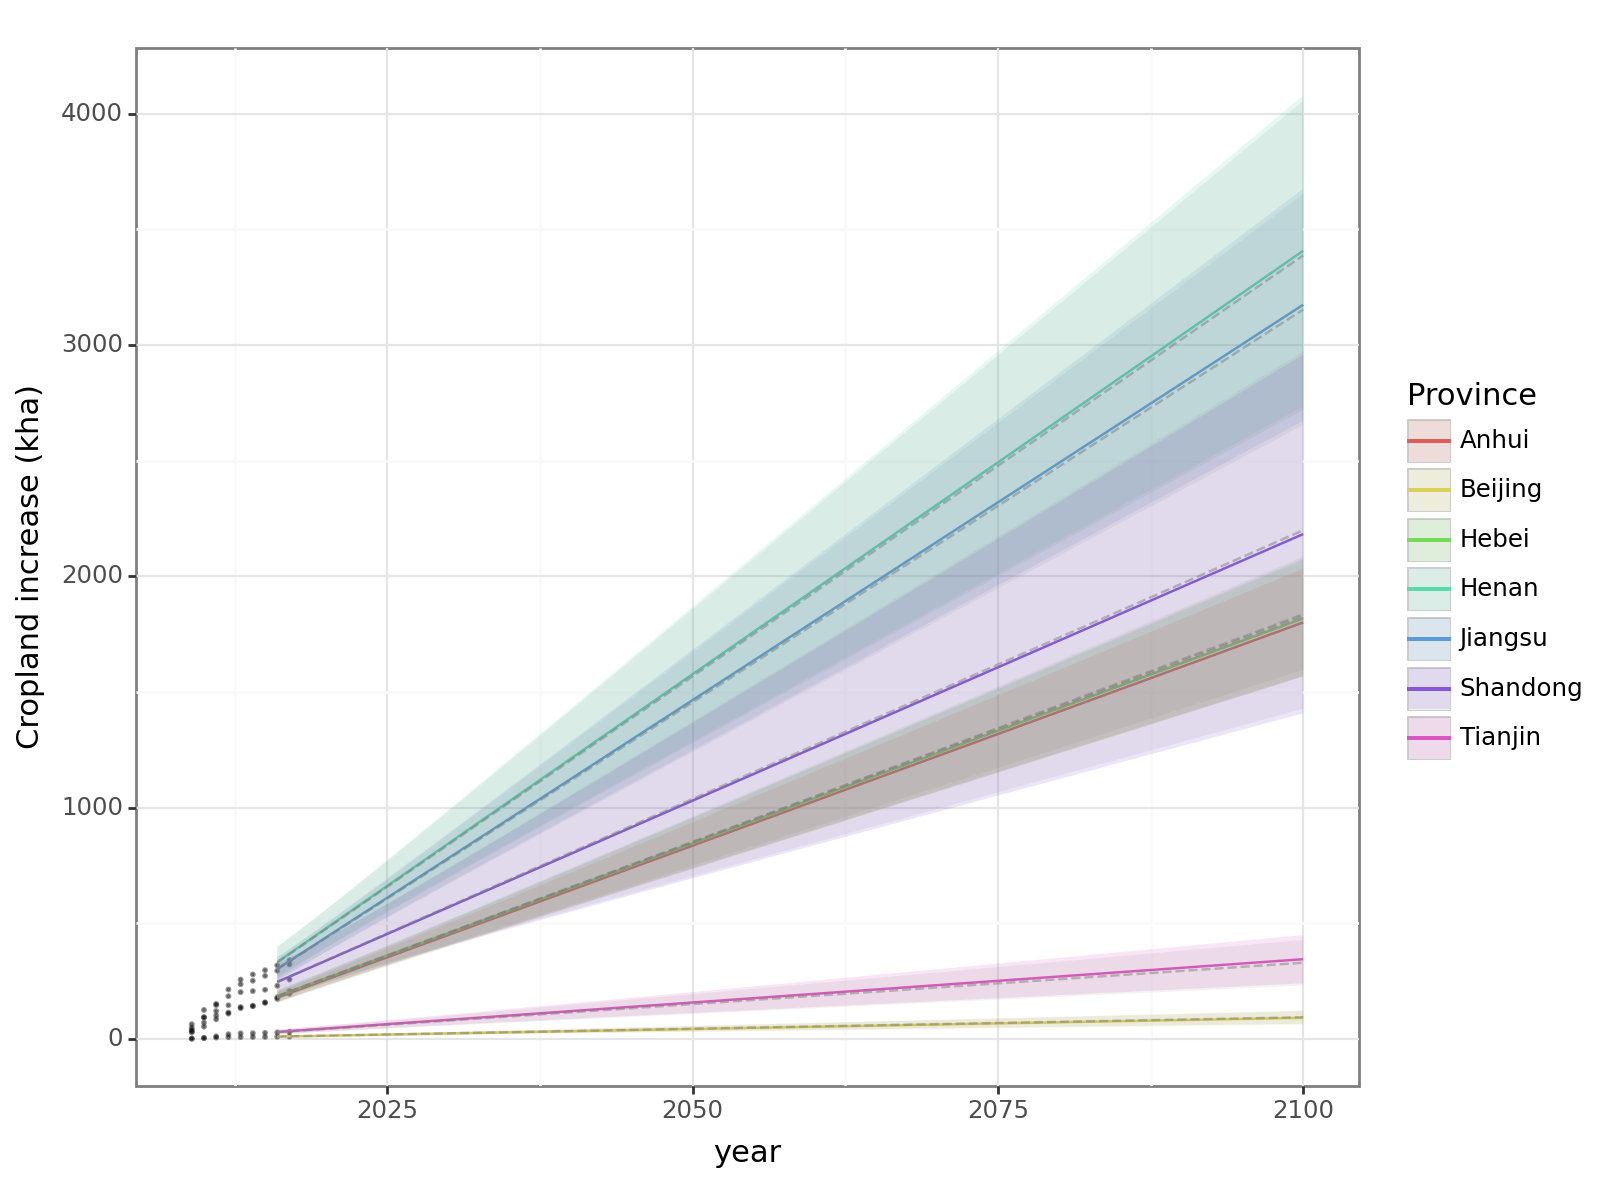

<Figure Size: (800 x 600)>

In [68]:
# seperate df for ploting
df_validate_pred = df_validate >> mask(X.year > 2015)   

# plot the area change
plotnine.options.figure_size = (8,6)
plotnine.options.dip = 100

(ggplot()
 # historical cropland increase
 + geom_point(cropland_increase_yearbook_NCP,aes(x='year',y='yearbook_cumsum_increase_kha'),size=0.2,alpha=0.4)
 # pred cropland increase
 + geom_line(df_validate_pred,aes(x='year',y='mean',color='Province'))
 + geom_ribbon(df_validate_pred,aes(x='year',ymin='obs_ci_lower',ymax='obs_ci_upper',fill='Province'),alpha=0.15)
 # pred cropland increase computed from img layers
 + geom_line(df_validate_pred,aes(x='year',y='area_kha',group='Province'),color='grey',linetype='dashed',alpha=0.5)
 + geom_ribbon(df_validate_pred,aes(x='year',ymin='area_kha_top',ymax='area_kha_bot',group='Province'),fill='grey',alpha=0.1)
 + theme_bw()
 + ylab('Cropland increase (kha)')    
)